# Data science course and curriculum design

To design our curriculum we searched for gaps between skills _(technical skills and soft skills)_ required for data science jobs, what is being taught in online courses, and what is being taught in university courses. This notebook will present our process for:
- Web scraping relevant job and online course data. 
- Cleaning the data and extracting relevant skills of interest
- Looking at what is taught in data science programs at other universities
- Identifying gaps between industry and academia to inform the design of our curriculum. 

We used the following sources to generate our datasets: 
1. [SimplyHired](https://www.simplyhired.ca/) to scrape datascience jobs
2. [Coursera](https://www.coursera.org/) to scrape online datascience courses
3. Kaggle survey of Data Scientists [2018](https://www.kaggle.com/kaggle/kaggle-survey-2018) and [2019](https://www.kaggle.com/c/kaggle-survey-2019) for data on people already working in industry

In [1]:
!pip install bs4
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from bs4 import BeautifulSoup

from IPython.display import HTML

import datetime,ast,re,time,urllib

## 1. Web Scraping: job and online course data

1.1 and 1.2 will walk through the webscraping processes for SimplyHired and Coursera, respectively. The Kaggle survey data is already available as a downloadable csv

### 1.1 Webscraping SimplyHired

SimplyHired is a website that aggregates thousands of job postings. These job posting sites contain the same jobs, and adding them together would make it difficult to identify duplicate jobs, resulting in double-counting certain postings. SimplyHired was chosen because it presents the data in a manner that it can easily be accessed via web scraping.  We being by reading the URL for one page search of `Data Science`.

In [2]:
url = urllib.request.urlopen('https://www.simplyhired.ca/search?q=Data+Science&l=Ontario')
content = url.read()
soup = BeautifulSoup(content, 'html.parser')

We can see how many job postings there are for this search:

In [3]:
# This block of code gets the total number of job postings
span = soup.find_all(name='span', attrs={'class':'posting-total'})
# Parse string 
totstr = str(span)
startt = totstr.find('<span class="posting-total">')
endd = totstr.find('</span>')
totstr = totstr[startt+28:endd]
totstr = totstr.replace(',', '')
total = int(totstr)
print(total, 'job postings found')

3330 job postings found


There were over 4200 jobs when we first ran the notebook (February 18th, 2020) and on March 29th there are 3404 jobs. COVID-19 is clearly taking a toll...

__Define Job Key Extraction Function__

This function finds the unique identifier for each job from each page, so that we can access the URL of each posting. We can also use this function to determine the number of postings per page.

In [4]:
def extract_job_key(soup): 
    jobs = []
    #print(soup.find_all(name='div', attrs={'class':'SerpJob-jobCard card isp'}))
    for div in soup.find_all(name='div', attrs={'class':'SerpJob-jobCard card isp'}):
        #print(div.find_all(name='a')
        job_key = div['data-jobkey']
        jobs.append(job_key)
    for div in soup.find_all(name='div', attrs={'class':'SerpJob-jobCard card'}):
        job_key = div['data-jobkey']
        jobs.append(job_key)
    return(jobs)

In [5]:
post_per_page = len(extract_job_key(soup))

In [6]:
num_pages = int(np.trunc(total/post_per_page)+1)
print('There are', num_pages, 'pages of job postings on SimplyHired')

There are 129 pages of job postings on SimplyHired


Now we will get the URL of each page of job postings. The URLs follow a simple structure, so we can just add the page number to the base URL.

In [7]:
initial_URL = 'https://www.simplyhired.ca/search?q=Data+Science&l=Ontario'
subsequent_URL = 'https://www.simplyhired.ca/search?q=Data+Science&l=Ontario&pn='
URL = []

for i in range(0,num_pages):
   if i == 0:
     URL.append(initial_URL)
   else:
     name = subsequent_URL+str(i+1)
     URL.append(name)

For example:

In [8]:
print(URL[2])

https://www.simplyhired.ca/search?q=Data+Science&l=Ontario&pn=3


Now, we need to get the ID of each job from each page of results. This block of code takes a while to run, so it is commented out. Instead of scraping real-time job data for the analysis, we will use job data from February 18th, stored in a csv file: SimplyHired_jobs.csv. 

In [9]:
# allkeys = []
# for i in range(0,num_pages):
#    url = urllib.request.urlopen(URL[i])
#    content = url.read()
#    soup = BeautifulSoup(content, 'html.parser')
#    keys_onepage = extract_job_key(soup)
#    allkeys.append(keys_onepage)

In [10]:
def flatten(l):
  out = []
  for item in l:
    if isinstance(item, (list, tuple)):
      out.extend(flatten(item))
    else:
      out.append(item)
  return out

# allkeys = flatten(allkeys)

Now, we can get the URL of every job posting:

In [11]:
# job_URL = []
# base_URL = 'https://www.simplyhired.ca/job/'

# for i in range(0,len(allkeys)):
#     url_ = base_URL+allkeys[i]
#     job_URL.append(url_)

In [12]:
# print(len(job_URL))

Now we can start getting information about jobs. Multiple functions are written to extract various attributes from the job postings. We begin with job description:

In [13]:
# This function gets job descriptions
def get_job_description(soup): 
  jobs = []
  #print(soup.find_all(name='div', attrs={'class':'viewjob-description ViewJob-description'}))
  for div in soup.find_all(name='div', attrs={'class':'viewjob-description ViewJob-description'}):
        conv = str(div)
        
        jobs.append(conv)
  return(jobs)


We can get the education level and job skills, which are listed as separate fields in SimplyHired:

In [14]:
def get_education_skills(soup): 
    edu_skill = str(soup.find_all(name='div', attrs={'class':'viewjob-entities'}))
    edu_start = edu_skill.find('Education')
    skill_start = edu_skill.find('Skills')
    edu = edu_skill[edu_start:skill_start]
    skills = edu_skill[skill_start:len(edu_skill)]
    ind_deg = [m.start() for m in re.finditer('<li class="nav-item">', edu)]
    ind_skill = [m.start() for m in re.finditer('<li class="nav-item">', skills)]

    sk = []
    for i in range(0, len(ind_skill)):
        dum = skills[ind_skill[i]+21:]
        dum2 = dum.find('</li>')
        dum3 = dum[0:dum2]
        sk.append(dum3)

    ed = []
    for i in range(0, len(ind_deg)):
        dum = edu[ind_deg[i]+21:]
        dum2 = dum.find('</li>')
        dum3 = dum[0:dum2]
        ed.append(dum3)
    return(ed,sk)


We can also get the job title, location, and company name:

In [15]:
def get_title_comp_loc(soup):
    dum=soup.find(name='div', attrs={'class':'viewjob-header'}).get_text('~')
    ind = [m.start() for m in re.finditer('~', dum)]
    title = dum[0:ind[0]]
    company = dum[ind[0]+1:ind[1]]
    if dum[ind[2]+1:].find('~') == -1 : 
        location = dum[ind[2]+1:]
    else:
        location = dum[ind[2]+1:ind[3]]
    #print(dum)
    return(title,company,location)

We are now ready to scrape every job posting. We will comment out this block and import the output dataframe as a csv as it takes a while to run.

In [16]:
'''# This cell is also super slow, may crash due to the amount of requests

description = []
education = []
skills = []
title = []
company = []
location = []
skills_str = []


for i in range(0,len(job_URL)): 
    print('crawled job # ',i)
    url = urllib.request.urlopen(job_URL[i])
    content = url.read()
    soup = BeautifulSoup(content, 'html.parser')
    
    dum = get_job_description(soup)
    ed,sk = get_education_skills(soup)
    tit,comp,loc = get_title_comp_loc(soup)
    
#     description.append(dum)
#     education.append(ed)
#     skills.append(sk)
#     title.append(tit)
#     company.append(comp)
#     location.append(loc)

    d2='|'.join(dum)
    e2='|'.join(ed)
    s2='|'.join(sk)
    t2=tit
    c2=comp
    l2=loc
    
    if np.trunc(i/10) == i/10: # Every 10th entry
        time.sleep(3)
        print('paused for 3 seconds')

    description.append(d2)
    education.append(e2)
    skills.append(s2)
    title.append(t2)
    company.append(c2)
    location.append(l2)
    skills_str.append(sk)
     

d = {'Title': title, 'Company': company, 'location' : location, 'education' : education, 'skills' : skills, 'Description' : description}

job_data = pd.DataFrame(data=d)'''
print ('')

Instead of scraping data, we can read the data from a csv file.

In [17]:
job_data=pd.read_csv('SimplyHired_Jobs.csv')

In [18]:
job_data.head()

,Title,Company,location,education,skills,Description
0,Waste Program Officer,Canadian Nuclear Laboratories,"Chalk River, ON",Bachelor's Degree,Computer Skills|Computer Literacy|Writing Skills,"<div class=""viewjob-description ViewJob-descri..."
1,Data Scientist,Canadian Tire,"Welland, ON",Bachelor's Degree,SQL|Tableau|Financial Services|SAS|R,"<div class=""viewjob-description ViewJob-descri..."
2,Data Engineer,Prodigy Game,"Oakville, ON",Bachelor's Degree|Master's Degree,NoSQL|SQL|AWS|Spark|Scala,"<div class=""viewjob-description ViewJob-descri..."
3,Solutions Architect,WCG Services,"Peel, ON",NaN,Time Management|SQL|Azure|Analysis Skills|Lead...,"<div class=""viewjob-description ViewJob-descri..."
4,Manager - Data and Analytics,ISG Search Inc,"Toronto, ON",Bachelor's Degree,Tableau|SAP|Microsoft SQL Server|SAP BusinessO...,"<div class=""viewjob-description ViewJob-descri..."


### 1.2 Webscraping Coursera 

Coursera is a popular online learning platform. 30 pages of data science, machine learning and AI related courses were scraped from the website. Again, these blocks take a while to run, so they will be commented out and the final dataframe can be read.

In [19]:
all_pages = []
for i in range (1,30):
  page_template = 'https://www.coursera.org/courses?query=&indices%5Bprod_all_products_term_optimization%5D%5Bpage%5D={}&indices%5Bprod_all_products_term_optimization%5D%5Bconfigure%5D%5BclickAnalytics%5D=true&indices%5Bprod_all_products_term_optimization%5D%5Bconfigure%5D%5BruleContexts%5D%5B0%5D=en&indices%5Bprod_all_products_term_optimization%5D%5Bconfigure%5D%5BhitsPerPage%5D=10&configure%5BclickAnalytics%5D=true'.format(i)
  all_pages.append(page_template)

Scrape basic course infomation (Title, offered by, difficulty, rating, enrollment number)

In [20]:
'''course_info = []

for page in all_pages:
  url = urllib.request.urlopen(page)
  content = url.read()
  soup = BeautifulSoup(content, 'lxml')

  course_data = soup.findAll('li',{'class':'ais-InfiniteHits-item'})
  for courses in course_data:
    partner = courses.find('span',{'class':'partner-name'}).get_text()
    title = courses.find(class_='color-primary-text card-title headline-1-text').get_text()
    #try:
      #level = courses.find('div',{'class':'productTypePill_up9419'}).get_text()
    #except AttributeError:
      #level = 'Unknow'
    difficulty = courses.find(class_='difficulty').get_text()
    rating = courses.find('span', {'class':'ratings-text'}).get_text()
    try:
      enrollment = courses.find('span',{'class':'enrollment-number'}).get_text()
    except AttributeError:
      enrollment = 'Unknown'
    course_info.append((title,partner,difficulty,rating,enrollment))'''

"course_info = []\n\nfor page in all_pages:\n  url = urllib.request.urlopen(page)\n  content = url.read()\n  soup = BeautifulSoup(content, 'lxml')\n\n  course_data = soup.findAll('li',{'class':'ais-InfiniteHits-item'})\n  for courses in course_data:\n    partner = courses.find('span',{'class':'partner-name'}).get_text()\n    title = courses.find(class_='color-primary-text card-title headline-1-text').get_text()\n    #try:\n      #level = courses.find('div',{'class':'productTypePill_up9419'}).get_text()\n    #except AttributeError:\n      #level = 'Unknow'\n    difficulty = courses.find(class_='difficulty').get_text()\n    rating = courses.find('span', {'class':'ratings-text'}).get_text()\n    try:\n      enrollment = courses.find('span',{'class':'enrollment-number'}).get_text()\n    except AttributeError:\n      enrollment = 'Unknown'\n    course_info.append((title,partner,difficulty,rating,enrollment))"

Obtain links to each individual course page

In [21]:
'''course_links = []
for page in all_pages:
  url = urllib.request.urlopen(page)
  content = url.read()
  soup = BeautifulSoup(content, 'lxml')
  
  course_lists = soup.find_all('li',{'class': 'ais-InfiniteHits-item'})
  for course_urls in course_lists:
    urls = course_urls.find('a')
    url = urls.get('href')
    url_complete = 'https://www.coursera.org{}'.format(url)
    course_links.append(url_complete)'''

"course_links = []\nfor page in all_pages:\n  url = urllib.request.urlopen(page)\n  content = url.read()\n  soup = BeautifulSoup(content, 'lxml')\n  \n  course_lists = soup.find_all('li',{'class': 'ais-InfiniteHits-item'})\n  for course_urls in course_lists:\n    urls = course_urls.find('a')\n    url = urls.get('href')\n    url_complete = 'https://www.coursera.org{}'.format(url)\n    course_links.append(url_complete)"

Scrape course descriptions

In [22]:
'''course_about = []
for link in course_links:
  url1 = urllib.request.urlopen(link)
  content1 = url1.read()
  soup1 = BeautifulSoup(content1, 'lxml')

  course_des = soup1.findAll('div',{'data-e2e':'description'})
  for course in course_des:
    description = course.get_text()
    #try:
     # description = course.find('div',{'class':'description'}).get_text()
    #except AttributeError:
     # description = course.find('div',{'class':'description'}).get_text()
    #print(description)
    course_about.append(description)'''

"course_about = []\nfor link in course_links:\n  url1 = urllib.request.urlopen(link)\n  content1 = url1.read()\n  soup1 = BeautifulSoup(content1, 'lxml')\n\n  course_des = soup1.findAll('div',{'data-e2e':'description'})\n  for course in course_des:\n    description = course.get_text()\n    #try:\n     # description = course.find('div',{'class':'description'}).get_text()\n    #except AttributeError:\n     # description = course.find('div',{'class':'description'}).get_text()\n    #print(description)\n    course_about.append(description)"

Scrape skills one will obtain upon completing the courses

In [23]:
'''skills_sum = []
for link in course_links:
  url2 = urllib.request.urlopen(link)
  content2 = url2.read()
  soup2 = BeautifulSoup(content2, 'lxml')

  skills_set = soup2.findAll('span',{'class':'Pill_56iw91 m-r-1s m-b-1s'})
  #print(skills)
  for skills in skills_set:
    skill = skills.get_text()
    skills_sum.append(skill)
    #print(skills_sum)'''

"skills_sum = []\nfor link in course_links:\n  url2 = urllib.request.urlopen(link)\n  content2 = url2.read()\n  soup2 = BeautifulSoup(content2, 'lxml')\n\n  skills_set = soup2.findAll('span',{'class':'Pill_56iw91 m-r-1s m-b-1s'})\n  #print(skills)\n  for skills in skills_set:\n    skill = skills.get_text()\n    skills_sum.append(skill)\n    #print(skills_sum)"

In [24]:
'''courses_summary_df = pd.DataFrame(course_info, columns=['Title','Offered by','Difficulty','Rating','Enrollment'])
brief_des_df = pd.DataFrame(course_about,columns=['Description'])
skills_sum_df = pd.DataFrame(skills_sum, columns=['Skills'])
coursera_df = pd.concat([courses_summary_df,brief_des_df],axis=1)
coursera_df.to_csv('./coursera.csv',index=False)'''

"courses_summary_df = pd.DataFrame(course_info, columns=['Title','Offered by','Difficulty','Rating','Enrollment'])\nbrief_des_df = pd.DataFrame(course_about,columns=['Description'])\nskills_sum_df = pd.DataFrame(skills_sum, columns=['Skills'])\ncoursera_df = pd.concat([courses_summary_df,brief_des_df],axis=1)\ncoursera_df.to_csv('./coursera.csv',index=False)"

In [25]:
#skills_sum_df = pd.DataFrame(skills_sum, columns=['Skills'])
#skills_sum_df.to_csv('./coursera_skills.csv')

In [26]:
coursera_df=pd.read_csv('coursera.csv')
skills_sum_df = pd.read_csv('./coursera_skills.csv')

In [27]:
coursera_df.head()

,Title,Offered by,Difficulty,Rating,Enrollment,Description
0,IBM Data Science,IBM,Beginner,4.6,370k,Data Science has been ranked as one of the hot...
1,Introduction to Data Science,IBM,Beginner,4.6,240k,In this Specialization learners will develop f...
2,Google IT Support,Google,Beginner,4.8,260k,"This 5-course certificate, developed by Google..."
3,Deep Learning,deeplearning.ai,Intermediate,4.8,580k,"If you want to break into AI, this Specializat..."
4,Python for Everybody,University of Michigan,Beginner,4.8,1.1m,This Specialization builds on the success of t...


## 1.3 Kaggle Survey - 2018 and 2019 

These datasets will allow us to look at what kind of skills and tools are being used by people currently working data science jobs. We can simply read in the data from a CSV file, so no scraping is required here.

## 2. Cleaning and Exploratory analysis

We will show for our three data sources how the data were cleaned and analyzed to identify relevant and important industry skills. As we are dealing with text data, we will be applying natural language processing algorithms to clean and analyze our data

In [28]:
!pip install nltk
import nltk
from nltk.corpus import stopwords 
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer

from collections import Counter
import pprint 


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.1 SimplyHired cleaning and EDA

We'll start by cleaning the dataframe. First, we filter the irrelevant jobs out. To do this, we will create a list of keywords for jobs we want to retain and filter our dataframe.

In [29]:
job_data['title'] = job_data["Title"].str.lower() 

In [30]:
relevant_titles = set(['data scientist','data science','data engineer','data and analytics','machine learning','artificial intelligence','big data','data analyst','data visualization',
                       'asset intelligence','digital analytics'])


See if Job Title contains relevant job title:

In [31]:
pattern = '|'.join(relevant_titles)
job_data['relevant'] = job_data.title.str.contains(pattern)
print(pattern)

machine learning|data engineer|data analyst|asset intelligence|data visualization|digital analytics|data and analytics|data scientist|big data|artificial intelligence|data science


In [32]:
job_data = job_data[job_data.relevant != False]

In [33]:
print('After removing irrelevant jobs, there are now', len(job_data.index), 'jobs.')

After removing irrelevant jobs, there are now 633 jobs.


Because SimplyHired aggregates many jobs, there are duplicate jobs from the same company. This will skew our dataset incorrectly, so, we want to filter out duplicate jobs. A job is assumed to be a duplicate if it has an identical title, company and location as another job. This is unlikely to result in different jobs being deleted. 

In [34]:
# sorting by first name 
job_data.sort_values("title", inplace = True) 
  
# dropping ALL duplicte values 
job_data.drop_duplicates(subset =['title','Company','location'], 
                     keep = 'first', inplace = True) 

In [35]:
print('After removing duplicates, there are now', len(job_data.index), 'jobs total.')

After removing duplicates, there are now 270 jobs total.


__Now, from our data we want to see what skills are in highest demand. We will present 2 different methods for doing this:__

__2.1.1 Method 1: Skill Field - Number of Occurences__

The postings on SimplyHired contain a "skills" field, where the employer can highlight skills that are important for the job. We will count the occurrence of skills using this field. This field contains up to 5 (and as few as zero) highlighted skills. We will read these from the dataframe:

In [36]:
job_skills = []
# job_data_old.skills[:]
jd=job_data.copy()
# dropping null value columns to avoid errors 
jd.dropna(inplace = True) 
   
# new data frame with split value columns 
Skill_df= jd["skills"].str.split("|", expand = True) 
Skill_df.columns = ['skill1','skill2','skill3',
                     'skill4','skill5']

In [37]:
# Write skill counts
string_skills = Skill_df.skill1.tolist()
string_skills.append(Skill_df.skill2.tolist())
string_skills.append(Skill_df.skill3.tolist())
string_skills.append(Skill_df.skill4.tolist())
string_skills.append(Skill_df.skill5.tolist())

d = Counter(flatten(string_skills))

n, m = d.keys(), d.values()

pprint.pprint(dict(d.items()))


{None: 47,
 'A/B Testing': 3,
 'AI': 14,
 'AWS': 38,
 'Adobe Analytics': 1,
 'Agile': 6,
 'Analysis Skills': 25,
 'Angular': 1,
 'Apache Hive': 17,
 'Apache Pig': 3,
 'Azure': 14,
 'B2B Sales': 1,
 'Big Data': 11,
 'Business Analysis': 2,
 'C/C++': 3,
 'Cassandra': 1,
 'Cognos': 1,
 'Computer Literacy': 6,
 'Conflict Management': 1,
 'Continuous Integration': 3,
 'Conversion Optimization': 1,
 'Customer Segmentation': 1,
 'Customer Service': 2,
 'DB2': 1,
 'Data Analysis Skills': 4,
 'Data Mining': 24,
 'Data Visualization': 4,
 'Data Warehouse': 16,
 'Database Marketing': 1,
 'Digital Marketing': 1,
 'Excel': 14,
 'Financial Services': 8,
 'Forecasting': 1,
 'Git': 10,
 'Go': 2,
 'Google Analytics': 1,
 'Google Cloud Platform': 10,
 'GraphQL': 1,
 'HTML5': 3,
 'Hadoop': 49,
 'Image Processing': 1,
 'Java': 19,
 'Jira': 1,
 'Kubernetes': 6,
 'Leadership Experience': 6,
 'Machine Learning': 19,
 'Management Experience': 3,
 'Market Research': 1,
 'Marketing': 1,
 'Microsoft Project': 1,

In [38]:
sklist_csv = list(set(flatten(string_skills)))
sklist_cs=[]
i=0
for skill in sklist_csv:
    sklist_cs.append(str(skill).lower())

Now we will plot the distribution of skills.

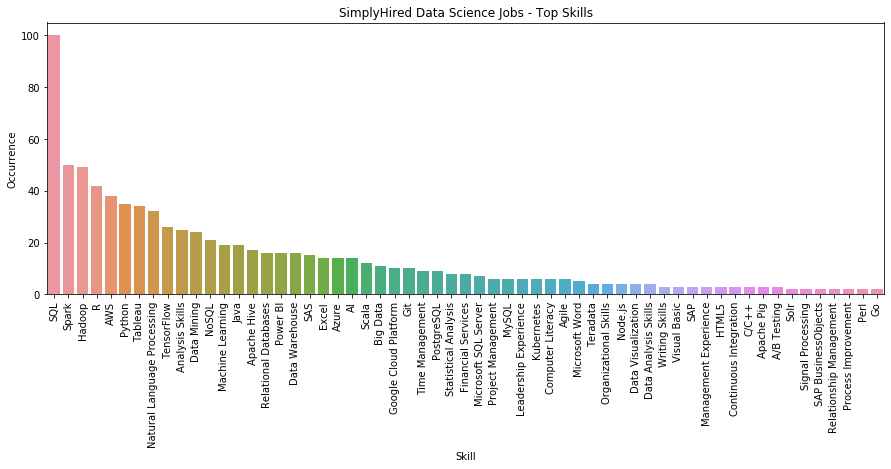

In [39]:
skill=list(d.keys())
occurrence=list(d.values())

skill = [x for _,x in sorted(zip(occurrence,skill),reverse=True)]
occurrence = sorted(occurrence,reverse=True)

job_skill=skill
job_skill_occurrence=occurrence

top_sk = 60

fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
plott=sns.barplot(x=skill[0:top_sk],y=occurrence[0:top_sk])
plott.set(xlabel='Skill', ylabel='Occurrence',title='SimplyHired Data Science Jobs - Top Skills')
plott.set_xticklabels(plott.get_xticklabels(), rotation=90)
plt.show()

Based on skill frequency alone, it seems that SQL, Spark, and Hadoop are the top 3 in-demand skills. It is of interest to note that all three of these skills are used in Big Data. However, job descriptions contain many skills, so perhaps we are losing information by simply using the "Skills" field. Some postings had no skills at all listed in this field. So we will now use the whole job description to gain more insight.

__2.1.2 Method 2: Search for skills in list in job description.__ 

We will create a master list of relevant skills obtained with Method 1 to search for skills in the job description field. We have manually modified this list to add certain skills. This method has potential to miss certain skills but we believe this one is the best method for us, provided that the master list of skills captures different ways of stating the skill. 

First, we need to create the master list of skills. First we will try to create a list based on the skills that occur in more than 3 course descriptions (from Coursera) or more than 3 job descriptions (from SimplyHired):

In [40]:
coursera_df.head()
skills_sum_df.head()
skills_count = skills_sum_df.Skills.value_counts().to_dict()

We will define a helper funciton for data cleaning to remove special characters.

In [41]:
def Punctuation(string): 
  
    # punctuation marks 
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  
    # traverse the given string and if any punctuation 
    # marks occur replace it with null 
    for x in string.lower(): 
        if x in punctuations: 
            string = string.replace(x, "") 
    outstr=str(string)
    return outstr
    # Print string without punctuation 

Create a list based on the skills that occur in more than 3 course descriptions (from Coursera) or more than 3 job descriptions (from SimplyHired):

In [42]:
# Import the data from the csv file we created with our RSS feed processor
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer(r'\w+')
sk_list = list(skills_count.keys())
sk_count = list(skills_count.values())
master_sk_list=[]
# Processing each article in our file

min_relevance = 3

i=0
for skill in sk_list:
    content_cleaned = ''

    # Remove non-alphabetic values and set all letters to lowercase
    #text = re.sub("[^A-Za-z']+", ' ', text).lower()
    skill = Punctuation(skill)
    skill = skill.lower()
    skill=stemmer.stem(skill)
    if sk_count[i] >= min_relevance:
        master_sk_list.append(skill)
    i+=1

sk_list = list(skills_count.keys())
sk_count = list(skills_count.values())
i=0


for skill in job_skill:
    content_cleaned = ''

    # Remove non-alphabetic values and set all letters to lowercase
    #text = re.sub("[^A-Za-z']+", ' ', text).lower()

    skill=str(skill)
    skill = Punctuation(skill)
    skill = skill.lower()
    skill=stemmer.stem(skill)
    if job_skill_occurrence[i] >= min_relevance:
        master_sk_list.append(skill)
    i+=1
print(master_sk_list)

['python program', 'machine learn', 'data analysi', 'data visualization dataviz', 'data sci', 'communic', 'tensorflow', 'sql', 'project manag', 'algorithm', 'r program', 'problem solv', 'deep learn', 'negoti', 'javascript', 'computer program', 'plan', 'write', 'leadership', 'market', 'cloud comput', 'debug', 'statist', 'manag', 'regression analysi', 'google cloud platform', 'financ', 'data structur', 'brand manag', 'strategic manag', 'objectoriented programming oop', 'cryptographi', 'cascading style sheets cc', 'analyt', 'microsoft excel', 'artificial intelligence ai', 'risk manag', 'business strategi', 'convolutional neural network', 'panda', 'mongodb', 'creativ', 'grammar', 'present', 'hash tabl', 'numpi', 'rstudio', 'artificial neural network', 'english languag', 'social media', 'apache spark', 'html', 'cloud storag', 'product manag', 'strategic think', 'troubleshoot', 'exploratory data analysi', 'google app engine ga', 'github', 'financial stat', 'project plan', 'account', 'applica

Unfortunately, this list is not in a form that is amenable to searching through documents. Some manual modifications were made to the list, for example some small words will need spaces inserted in front and behind, like ' r ', while some will not.  The skills were also sorted into soft skills and technical skills, manually. The final list:

In [43]:
soft_skills_tbc = ['accountability',
'accounting',
'analysis skills',
' art ',
'art history',
'b2b sales',
'balance sheet',
'business analy',
'brand management',
'business strategy',
'coaching',
'collaborat',
'communication',
'computer literacy',
'conflict management',
'consulting',
'creativ',
'customer service',
'database marketing',
'digital marketing',
'ethics',
'entrepreneurship',
'finance',
'financial services',
'independent',
'integrity',
'leadership experience',
'management experience',
'market research',
'marketing',
'negotiation',
'organizational skills',
'presentation',
'problem solving',
'project management',
'quantitative analy',
'relationship management',
'reporting',
'results oriented',
'risk management',
'speech',
'teaching',
'team',
'time management',
'writing']

tech_skills_tbc=[' ai ',
' aws ',
' c ',
' excel ',
' git ',
' ios ',
' java ',
' r ',
'a/b testing',
'adobe analytics',
'agile',
'angular',
'apache hive',
'apache pig',
'artificial intelligence',
'azure',
'big data',
'c/c++',
'c++',
'cascading style sheets',
'calculus',
'cassandra',
'cluster',
'cognos',
'colab',
'computer sci',
'continuous integration',
'conversion optimization',
'cron',
'customer segmentation',
'cryptography',
'data analysis skills',
'data architecture',
'data clean',
'data exploration',
'data governance',
'data mapping',
'data mining',
'data visualization',
'data warehouse',
'db2',
'deep learning',
'decision tree',
'forecasting',
'google',
'graph theory',
'graphql',
'hadoop',
'html',
'hash table',
'image processing',
'javascript',
'jira',
'jupyter',
'kubernetes',
'linear algebra',
'linux',
'machine learning',
'mathematic',
'matlab',
'microsoft project',
'microsoft sql server',
'microsoft word',
'mysql',
'natural language processing',
'neural network',
'node.js',
'none',
'nosql',
'optimization',
'oracle',
'perl',
'php',
'postgresql',
'power bi',
'process improvement',
'pycharm',
'python',
'qlikview',
'regression',
'relational database',
'rstudio',
'ruby',
's3',
'sap',
'sap businessobjects',
'sas',
'scala',
'shell scripting',
'signal processing',
'solr',
'spark',
'splunk',
'spss',
'sql',
'social media',
'simulation',
'statistic',
'storytelling',
'system design',
'systems management',
'tableau',
'tensorflow',
'teradata',
'test automation',
'tfs',
'unix',
'vba',
'visual analyitics',
'visual basic',
'visualization',
'web scraping'
'zeppelin',
'cloud',
'programming']
    

# Import the data from the csv file we created with our RSS feed processor
from nltk.stem.snowball import SnowballStemmer
SnowballStemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer(r'\w+')
soft_skills=[]
tech_skills=[]


for skill in tech_skills_tbc:

    skill = skill.lower()
    skill=stemmer.stem(skill)
    tech_skills.append(skill)

for skill in soft_skills_tbc:

    skill = skill.lower()
    skill=stemmer.stem(skill)
    soft_skills.append(skill)


Now we search through every job description for each skill in our master list. We will only count each skill once per job description. 

The text contains unneeded characters (eg., HTML tags). Here we strip all non-letter characters, make the text lowercase, remove stopwords, and count word frequency. We will only count each word once for each job description.

In [44]:
# Import the data from the csv file we created with our RSS feed processor
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
clean_text = []
tokenized_words = []
mega_list = []
tsk_count= np.zeros(len(tech_skills))
ssk_count= np.zeros(len(soft_skills))

# Processing each article in our file
for row in job_data['Description']:

    content_cleaned = ''

    text=re.sub('<.*?>', '', str(row))
    # Remove non-alphabetic values and set all letters to lowercase
    #text = re.sub("[^A-Za-z']+", ' ', text).lower()
    text = Punctuation(text)
    text = text.lower()

    
    
    i=0
    for skill in tech_skills:
        if text.find(skill) >=0:
            tsk_count[i] =tsk_count[i]+1
        i=i+1
        
    i=0
    for skill in soft_skills:
        if text.find(skill) >=0:
            ssk_count[i] =ssk_count[i]+1
        i=i+1
    
    clean_text.append(text)

    tokenized_words.append(content_cleaned.split())

job_data['Description_LC'] = clean_text

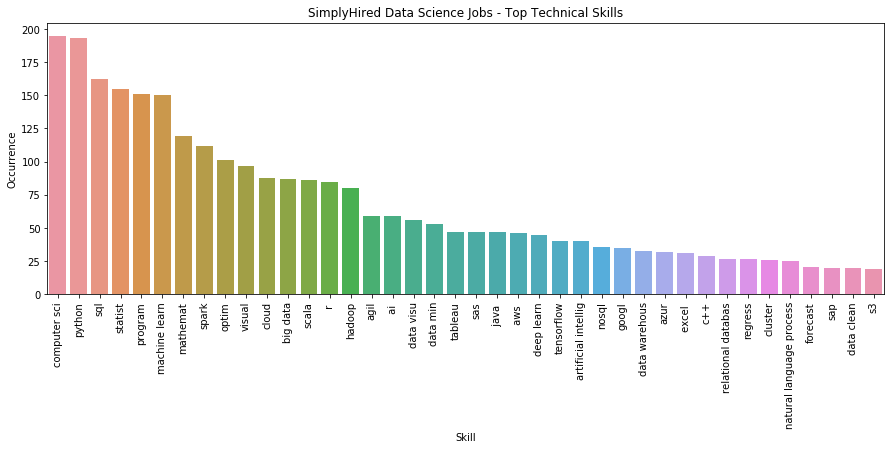

In [45]:
skill=list(tech_skills)
occurrence=list(tsk_count)

skill = [x for _,x in sorted(zip(occurrence,skill),reverse=True)]
occurrence = sorted(occurrence,reverse=True)

skill_job=skill
occurrence_job=occurrence

top_sk = 40

fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
plott=sns.barplot(x=skill[0:top_sk],y=occurrence[0:top_sk])
plott.set(xlabel='Skill', ylabel='Occurrence',title='SimplyHired Data Science Jobs - Top Technical Skills')
plott.set_xticklabels(plott.get_xticklabels(), rotation=90)
plt.show()

The top skills are computer sci(ence), python, sql, statist(ics) and programming. These are common data science skills, so this distribution is not unexpected. 

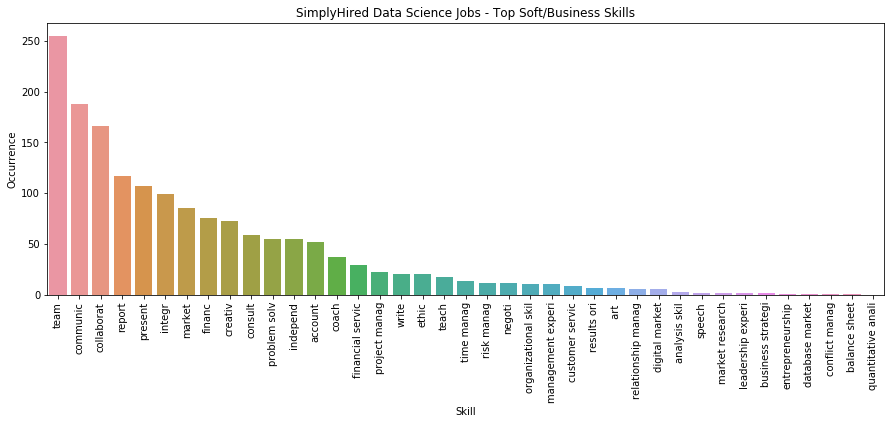

In [46]:
skill=list(soft_skills)
occurrence=list(ssk_count)

skill = [x for _,x in sorted(zip(occurrence,skill),reverse=True)]
occurrence = sorted(occurrence,reverse=True)

soft_skill_job=skill
soft_occurrence_job=occurrence

top_sk = 40

fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
plott=sns.barplot(x=skill[0:top_sk],y=occurrence[0:top_sk])
plott.set(xlabel='Skill', ylabel='Occurrence',title='SimplyHired Data Science Jobs - Top Soft/Business Skills')
plott.set_xticklabels(plott.get_xticklabels(), rotation=90)
plt.show()

The top skills are "team", communic(ation), collaborat(ion), report(ing), and present(ation). These important skills in academia and industry, and do not seem to be lacking in most courses. Marketing and finance however are not covered as frequently in engineering courses, so this is an important area to address in course design. 

In [47]:
job_data.to_csv("SimplyHired_Jobs_duplicates_removed.csv", index=False)

Now we can look at what skills are being taught in online courses:

### 2.2 Coursera cleaning and EDA

__2.1.1 Method 1: Skill Field - Number of Occurences__

Refering back to our coursera dataframe, we can now plot the top 20 skills that are taught by those courses. Coursera presents a similar "Skills" field to SimplyHired, where a few top skills in the course are highlighted. So based on this "skills" field, here are the top skills taught in online courses:

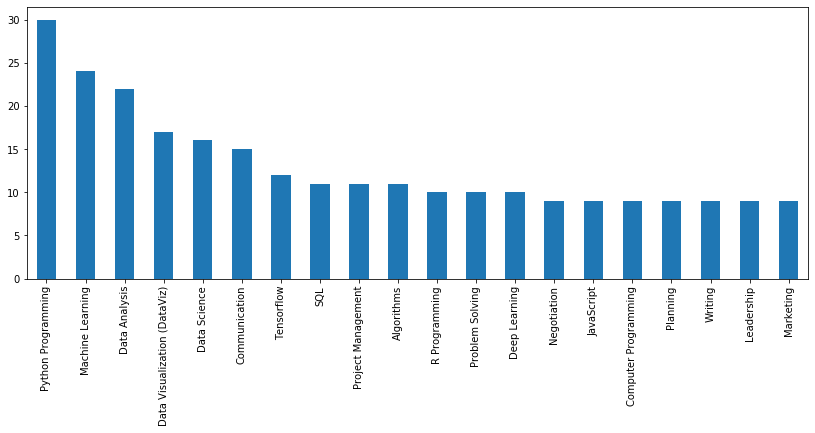

In [48]:
top_skills = skills_sum_df.Skills.value_counts()
top_skills[0:20].plot(kind='bar',figsize=(14,5))
plt.show()

The top skills are Python programming, machine learning, data analysis, data visualization and data science. While the distribution is similar to the top required skills in the job postings from SimplyHired, we are missing out on additional skills taught that are mentioned in the "Description" field, so we will now perform a search through all the course descriptions using the same list as we used for the job descriptions.

__2.1.2 Method 2: Search for skills in list in course description.__ 

Just as we did for job descriptions (2.1.2) we can clean the course descrption text and search for our hard and soft skills in the course descriptions:

In [49]:
# Import the data from the csv file we created with our RSS feed processor
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
clean_text = []
tokenized_words = []
mega_list = []
tsk_count= np.zeros(len(tech_skills))
ssk_count= np.zeros(len(soft_skills))

# Processing each article in our file
for row in coursera_df['Description']:

    content_cleaned = ''

    text=re.sub('<.*?>', '', str(row))
    # Remove non-alphabetic values and set all letters to lowercase
    #text = re.sub("[^A-Za-z']+", ' ', text).lower()
    text = Punctuation(text)
    text = text.lower()

    
    
    i=0
    for skill in tech_skills:
        if text.find(skill) >=0:
            tsk_count[i] =tsk_count[i]+1
        i=i+1
        
    i=0
    for skill in soft_skills:
        if text.find(skill) >=0:
            ssk_count[i] =ssk_count[i]+1
        i=i+1
    
    clean_text.append(text)

    tokenized_words.append(content_cleaned.split())

coursera_df['Description_LC'] = clean_text

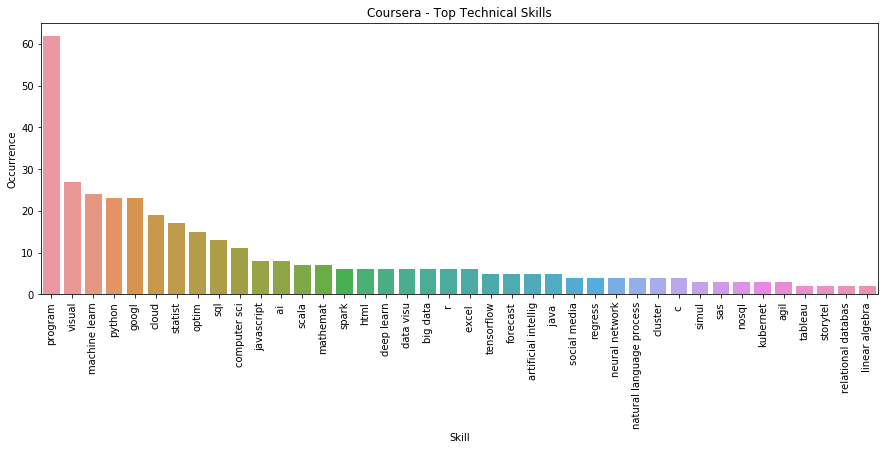

In [50]:
skill=list(tech_skills)
occurrence=list(tsk_count)

skill = [x for _,x in sorted(zip(occurrence,skill),reverse=True)]
occurrence = sorted(occurrence,reverse=True)

skill_course=skill
occurrence_course=occurrence

top_sk = 40

fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
plott=sns.barplot(x=skill[0:top_sk],y=occurrence[0:top_sk])
plott.set(xlabel='Skill', ylabel='Occurrence',title='Coursera - Top Technical Skills')
plott.set_xticklabels(plott.get_xticklabels(), rotation=90)
plt.show()

The top skills are program(ming) (by far), visual(ization), machine learn(ing), python and googl(e). There is considerable overlap with the job data from SimplyHired, though the distribution is different.

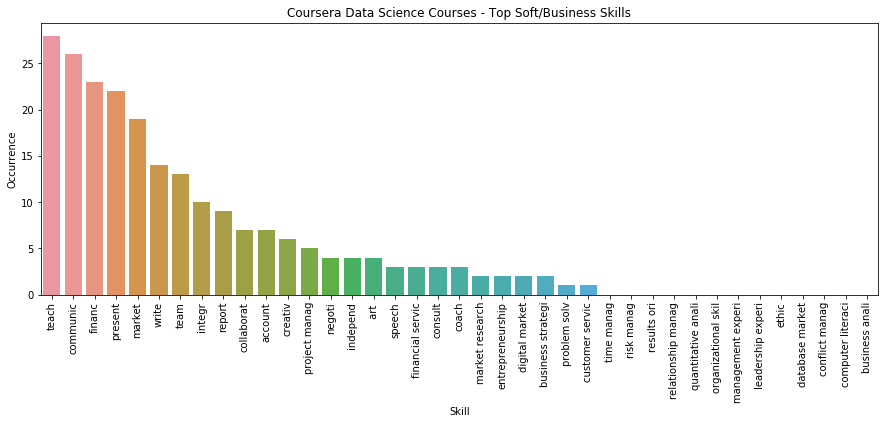

In [51]:
skill=list(soft_skills)
occurrence=list(ssk_count)

skill = [x for _,x in sorted(zip(occurrence,skill),reverse=True)]
occurrence = sorted(occurrence,reverse=True)

soft_skill_course=skill
soft_occurrence_course=occurrence

top_sk = 40

fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
plott=sns.barplot(x=skill[0:top_sk],y=occurrence[0:top_sk])
plott.set(xlabel='Skill', ylabel='Occurrence',title='Coursera Data Science Courses - Top Soft/Business Skills')
plott.set_xticklabels(plott.get_xticklabels(), rotation=90)
plt.show()

The top skills are teach(ing), communic(ation), financ(e), present(ation) and market(ing). These courses seem to be targeted towards employable skills, as there is considerable overlap with the job data from SimplyHired.

### Combining the SimplyHired and Coursera datasets:

Let's average these two datasets so that we can see which skills are more important overall. We will weight the Coursera and SimplyHired data equally, and normalize each dataset prior to averaging. We will normalize each dataset to the top skill, and assign the top skill a value of 0.5. 

In [52]:
# n_jobs=len(job_data.index)
# n_course=len((coursera_df.index))
n_jobs=occurrence_job[0]
n_course=occurrence_course[0]
sn_jobs=soft_occurrence_job[0]
sn_course=soft_occurrence_course[0]

skill_norm=skill_job
occurrence_norm=np.zeros(len(occurrence_job))
soft_skill_norm=soft_skill_job
soft_occurrence_norm=np.zeros(len(soft_occurrence_job))
occ_both_skill=np.zeros((len(occurrence_job),2))
occ_both_soft=np.zeros((len(soft_occurrence_job),2))

# This block computes the normalized skill count
i=0
for skill in skill_job:
    i_d=skill_course.index(skill)
    # We will give each dataset an equal priority
    occurrence_norm[i]=0.5*occurrence_job[i]/(n_jobs)+0.5*occurrence_course[i_d]/(n_course)
    occ_both_skill[i,0]=0.5*occurrence_job[i]/(n_jobs)
    occ_both_skill[i,1]=0.5*occurrence_course[i_d]/(n_course)
    i+=1 
         
i=0
for skill in soft_skill_job:
    i_d=soft_skill_course.index(skill)
    # We will give each dataset an equal priority
    soft_occurrence_norm[i]=0.5*soft_occurrence_job[i]/(sn_jobs)+0.5*soft_occurrence_course[i_d]/(sn_course)
    occ_both_soft[i,0]=0.5*soft_occurrence_job[i_d]/(sn_jobs)
    occ_both_soft[i,1]=0.5*soft_occurrence_course[i_d]/(sn_course)

    i+=1 

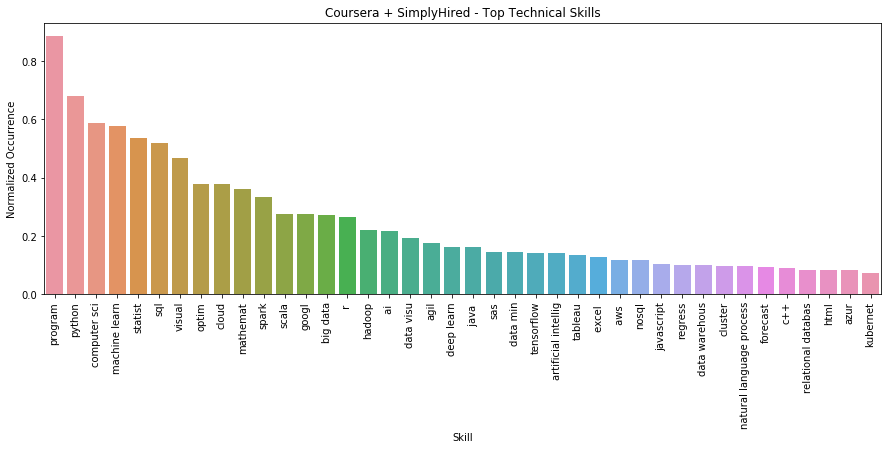

In [53]:
skill=skill_norm
occurrence=occurrence_norm

skill = [x for _,x in sorted(zip(occurrence,skill),reverse=True)]
occurrence = sorted(occurrence,reverse=True)

overall_skill=skill 
overall_occurrence=occurrence 

top_sk = 40

fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
plott=sns.barplot(x=skill[0:top_sk],y=occurrence[0:top_sk])
plott.set(xlabel='Skill', ylabel='Normalized Occurrence',title='Coursera + SimplyHired - Top Technical Skills')
plott.set_xticklabels(plott.get_xticklabels(), rotation=90)
plt.show()

This aggregate skill distribution will inform our course and program design. We can also visualize the distribution of skills separately for the Course and Job data:

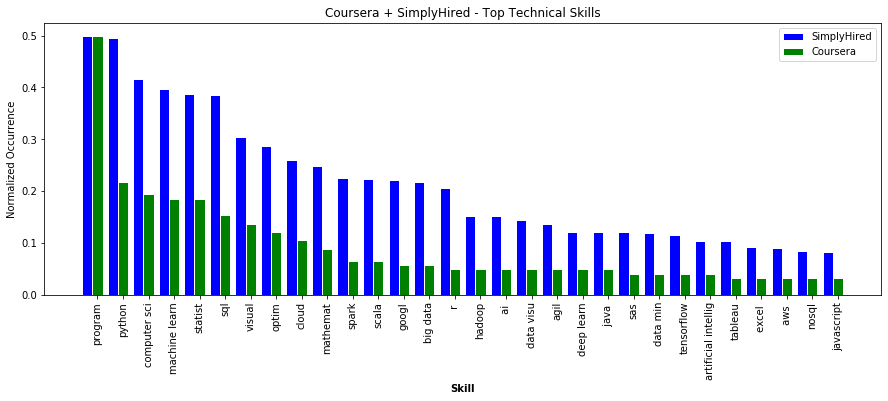

In [54]:
skill=skill_norm
occurrence=occurrence_norm

skill = [x for _,x in sorted(zip(occ_both_skill[:,0],skill),reverse=True)]
occurrenceSH = sorted(occ_both_skill[:,0],reverse=True)
occurrenceC = sorted(occ_both_skill[:,1],reverse=True)


top_sk = 30

# set width of bar
barWidth = 0.4
 
# set height of bar
bars1 = occurrenceSH[0:top_sk]
bars2 = occurrenceC[0:top_sk]

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
  
# Make the plot
plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='white', label='SimplyHired')
plt.bar(r2, bars2, color='g', width=barWidth, edgecolor='white', label='Coursera')
 
ax.set(xlabel='Skill', ylabel='Normalized Occurrence',title='Coursera + SimplyHired - Top Technical Skills')
plt.xlabel('Skill', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], skill[0:top_sk])

ax.set_xticklabels(plott.get_xticklabels(), rotation=90)
# Create legend & Show graphic
plt.legend()
plt.show()


Now, we will plot the soft skills combining course and job descriptions. Again, we will use this to evaluate our course curriculum. 

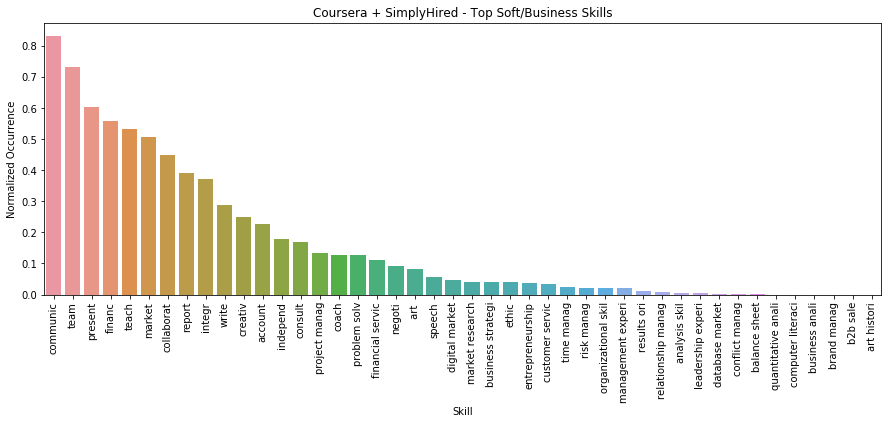

In [55]:
skill=soft_skill_norm
occurrence=soft_occurrence_norm

skill = [x for _,x in sorted(zip(occurrence,skill),reverse=True)]
occurrence = sorted(occurrence,reverse=True)

overall_soft_skill=skill
overall_soft_occurrence=occurrence

top_sk = 60

fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
plott=sns.barplot(x=skill[0:top_sk],y=occurrence[0:top_sk])
plott.set(xlabel='Skill', ylabel='Normalized Occurrence',title='Coursera + SimplyHired - Top Soft/Business Skills')
plott.set_xticklabels(plott.get_xticklabels(), rotation=90)
plt.show()

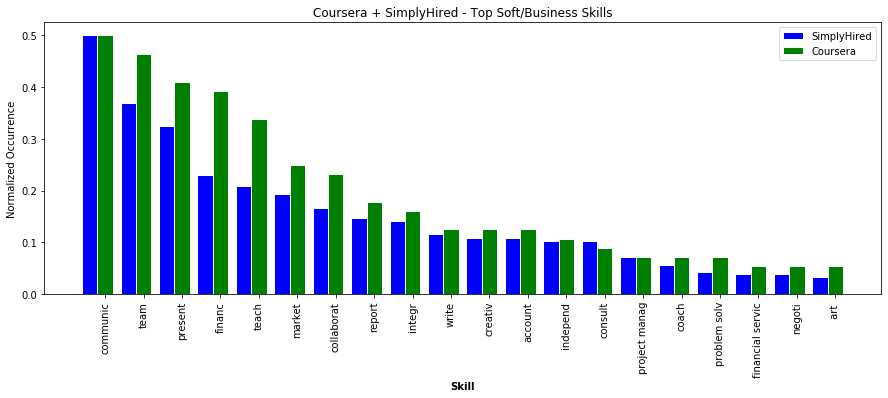

In [56]:
skill=soft_skill_norm

skill = [x for _,x in sorted(zip(occ_both_soft[:,0],skill),reverse=True)]
occurrenceSH = sorted(occ_both_soft[:,0],reverse=True)
occurrenceC = sorted(occ_both_soft[:,1],reverse=True)

top_sk = 20

# set width of bar
barWidth = 0.4
 
# set height of bar
bars1 = occurrenceSH[0:top_sk]
bars2 = occurrenceC[0:top_sk]

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
  
# Make the plot
plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='white', label='SimplyHired')
plt.bar(r2, bars2, color='g', width=barWidth, edgecolor='white', label='Coursera')
 
ax.set(xlabel='Skill', ylabel='Normalized Occurrence',title='Coursera + SimplyHired - Top Soft/Business Skills')
plt.xlabel('Skill', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], skill[0:top_sk])

ax.set_xticklabels(plott.get_xticklabels(), rotation=90)
# Create legend & Show graphic
plt.legend()
plt.show()

### 2.3 Kaggle Datascience Surveys EDA

The 2019 and 2019 data were cleaned in a similar way as assignment 1.

__2.3.1 Summary of the Data Cleaning__

the orginal data contains a lot of categorical data, that contains interval, texual data with a lot of nan values. The general strategy of handling the variable are: 

1.   checking the missing data and proportion of missing data, except for the columns with "part" (the options one)
2.   for small proportion, dropping the data, for large percentage, fill in with unknow as another character or fill in with the most common value if that account for over 70 percent of the all answers.
3.   for general catgorical textual data, us ethe dummy coding to make each value a binary variable
4.   for special numerical data, use the numerical coding
5.   for the columns with "parts", binarize the columns where replace all nah value as 0 and other text as 1.

We will import our cleaned data frames to show exploratory analysis :

In [57]:
SS = pd.read_csv('./salaryClean2018_final.csv')
SS.head()

,Q1,"('Q9_Part_1', 'Analyze and understand data to influence product or business decisions')","('Q9_Part_2', 'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data')","('Q9_Part_3', 'Build prototypes to explore applying machine learning to new areas')","('Q9_Part_4', 'Build and/or run a machine learning service that operationally improves my product or workflows')","('Q9_Part_5', 'Experimentation and iteration to improve existing ML models')","('Q9_Part_6', 'Do research that advances the state of the art of machine learning')","('Q9_Part_7', 'None of these activities are an important part of my role at work')","('Q9_Part_8', 'Other')","('Q12_Part_1', 'Twitter (data science influencers)')",...,Q23_4-5 years,Q23_5-10 years,Q23_< 1 years,Q23_unknow,Q22_2-5 times,Q22_6-24 times,Q22_> 25 times,Q22_Never,Q22_Once,Q22_unknow
0,23.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,42.0,1,1,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,42.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,23.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,52.0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


__2.3.2. Correlation Analysis__

We dercided to look at the correlation between skillsets and salaries. We believe this will give our program an advantage if we are able to teach students the skills that are in demand for high paying jobs.

In [58]:
#calculate correlation
corr = SS.corr()

# sorting the result and plot
correlation = corr.Q10_Encoded.apply(lambda x: abs(x)).sort_values()

Text(0.5, 1.0, 'TOP 50 most important features according to correlation with Salary')

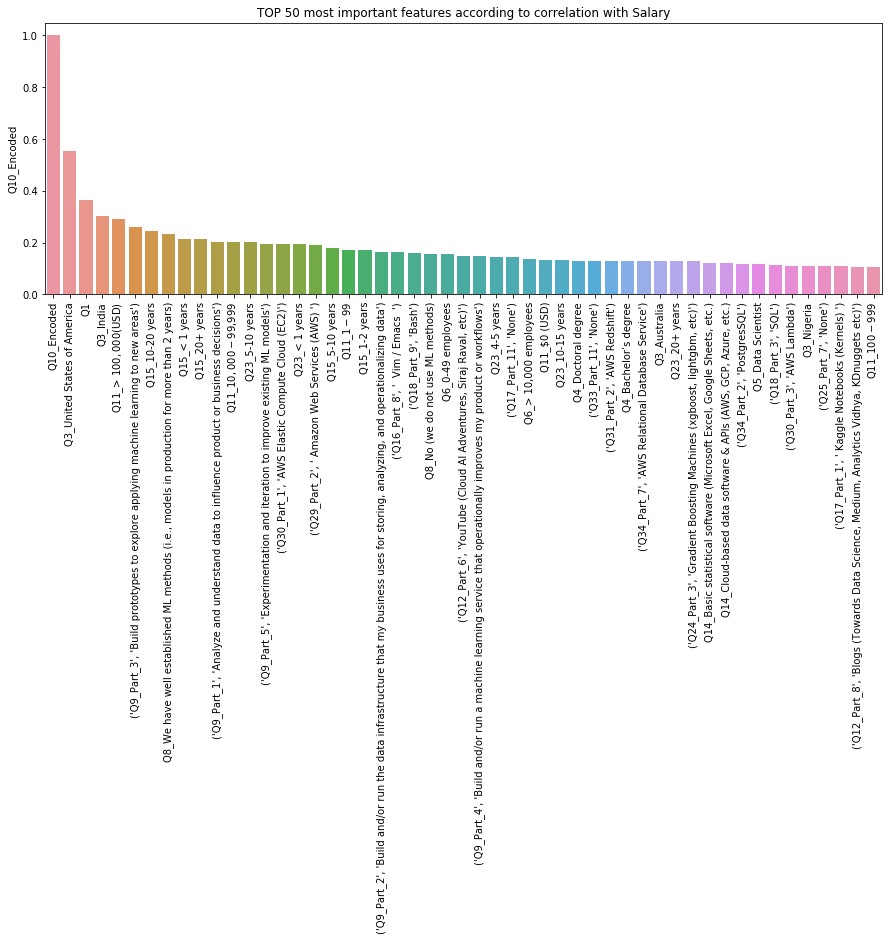

In [59]:
#print(correlation.sort_values(ascending=False)[1:50],"\n")
n=50
plt.figure(figsize=(15,5))
p=sns.barplot(x=correlation.sort_values(ascending=False)[0:n+1].index,y=correlation.sort_values(ascending=False)[0:n+1])
a = p.set_xticklabels(p.get_xticklabels(), rotation=90)
plt.title("TOP 50 most important features according to correlation with Salary")

**Summary of Insights**:

> In the ordered correlation list,  Whether know how to use **AWS** and AWS by-products is positively relavent to the salary, such as AWS Elastic computer cloud, AWS relational database, AWS redshift. An introduction toAWS and learning how to use AWS might be essential.

> in the orderded correltion list, whether knowling **machine learning** algorithm and whether using the ML tools and experience in using ML is also highly relavent to the salary level. learning how to apply and build ML is critical in the program.

> In the ordered list, the **basic statictical software**, such as excel,google sheets is also high relevent to the financial success, and a lot of language and algorithm appeared in the list also required a solid fundation on the **stats and linear algebra**.

> in the ordered list, relational data base management tools such as **SQL**,AWS relational database, has appeared several times which might also be consider in putting the course design

__2.3.3 Filtering and Ordering__

This section aims to find out the most common skill set for people who are relatively new in the industry but have relatively high salary, this will be more relevant to people who are just starting preparing themselves for the market

In [60]:
Salary = pd.read_csv('Kaggle_Salary.csv',low_memory=True)

C:\Users\David\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (73,77,114,146,153,171,175,212,224,228,231) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [61]:
filter2 = Salary["Q15"].isin(['1-2 years', '< 1 years','3-5 years'])
filter3 = Salary["Q10_Encoded"]>10
filter1 =Salary["Q23"].isin(['1-2 years', '2-3 years', '< 1 years', '3-4 years', '4-5 years'])

Salary_t=Salary[filter1 + filter2 + filter3]
print(Salary_t.shape)


(10126, 248)


C:\Users\David\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  op=op_str, alt_op=unsupported[op_str]


In [62]:
#value counts the tech skill columns
print("top primary tools used")
Salary_t.Q14.value_counts()

top primary tools used


Local development environments (RStudio, JupyterLab, etc.)              5327
Basic statistical software (Microsoft Excel, Google Sheets, etc.)       1765
Cloud-based data software & APIs (AWS, GCP, Azure, etc.)                 923
Other                                                                    719
Business intelligence software (Salesforce, Tableau, Spotfire, etc.)     705
Advanced statistical software (SPSS, SAS, etc.)                          597
Name: Q14, dtype: int64

In [63]:
print("what are the language that data scientists recommend to start first:  Python")
Salary_t.Q19.value_counts()

what are the language that data scientists recommend to start first:  Python


Python        7629
R              938
SQL            690
C++            114
MATLAB          96
Other           89
C               79
Java            60
None            53
Javascript      37
Bash            29
TypeScript       5
Name: Q19, dtype: int64

In [64]:
print("top Tools to analyze data used")
Salary_t.Q14.value_counts()

top Tools to analyze data used


Local development environments (RStudio, JupyterLab, etc.)              5327
Basic statistical software (Microsoft Excel, Google Sheets, etc.)       1765
Cloud-based data software & APIs (AWS, GCP, Azure, etc.)                 923
Other                                                                    719
Business intelligence software (Salesforce, Tableau, Spotfire, etc.)     705
Advanced statistical software (SPSS, SAS, etc.)                          597
Name: Q14, dtype: int64

In [65]:
print("top language used")
print(Salary_t.Q18_Part_1.value_counts())
print(Salary_t.Q18_Part_2.value_counts())
print(Salary_t.Q18_Part_3.value_counts())
print(Salary_t.Q18_Part_4.value_counts())
print(Salary_t.Q18_Part_6.value_counts())
print(Salary_t.Q18_Part_7.value_counts())
print(Salary_t.Q18_Part_8.value_counts())
print(Salary_t.Q18_Part_9.value_counts())

top language used
Python    8666
Name: Q18_Part_1, dtype: int64
R    3253
Name: Q18_Part_2, dtype: int64
SQL    5020
Name: Q18_Part_3, dtype: int64
C    826
Name: Q18_Part_4, dtype: int64
Java    1469
Name: Q18_Part_6, dtype: int64
Javascript    1615
Name: Q18_Part_7, dtype: int64
TypeScript    331
Name: Q18_Part_8, dtype: int64
Bash    1563
Name: Q18_Part_9, dtype: int64


In [66]:
print("top data visualization libaries used is Matplotlib and Gg plot ")
print(Salary_t.Q20_Part_1.value_counts())
print(Salary_t.Q20_Part_2.value_counts())
print(Salary_t.Q20_Part_3.value_counts())
print(Salary_t.Q20_Part_4.value_counts())
print(Salary_t.Q20_Part_6.value_counts())
print(Salary_t.Q20_Part_7.value_counts())
print(Salary_t.Q20_Part_8.value_counts())
print(Salary_t.Q20_Part_9.value_counts())

top data visualization libaries used is Matplotlib and Gg plot 
 Ggplot / ggplot2     2945
Name: Q20_Part_1, dtype: int64
 Matplotlib     6974
Name: Q20_Part_2, dtype: int64
 Altair     122
Name: Q20_Part_3, dtype: int64
 Shiny     951
Name: Q20_Part_4, dtype: int64
 Plotly / Plotly Express     2366
Name: Q20_Part_6, dtype: int64
 Bokeh     780
Name: Q20_Part_7, dtype: int64
 Seaborn     4661
Name: Q20_Part_8, dtype: int64
 Geoplotlib     455
Name: Q20_Part_9, dtype: int64


In [67]:
print("top ML algorithm used is linear and logistic regression and decision trees and gradient boosting machines, connvolutional neural networks ")
print(Salary_t.Q24_Part_1.value_counts())
print(Salary_t.Q24_Part_2.value_counts())
print(Salary_t.Q24_Part_3.value_counts())
print(Salary_t.Q24_Part_4.value_counts())
print(Salary_t.Q24_Part_6.value_counts())
print(Salary_t.Q24_Part_7.value_counts())
print(Salary_t.Q24_Part_8.value_counts())
print(Salary_t.Q24_Part_9.value_counts())

top ML algorithm used is linear and logistic regression and decision trees and gradient boosting machines, connvolutional neural networks 
Linear or Logistic Regression    6971
Name: Q24_Part_1, dtype: int64
Decision Trees or Random Forests    5921
Name: Q24_Part_2, dtype: int64
Gradient Boosting Machines (xgboost, lightgbm, etc)    3981
Name: Q24_Part_3, dtype: int64
Bayesian Approaches    2519
Name: Q24_Part_4, dtype: int64
Dense Neural Networks (MLPs, etc)    2160
Name: Q24_Part_6, dtype: int64
Convolutional Neural Networks    3560
Name: Q24_Part_7, dtype: int64
Generative Adversarial Networks    637
Name: Q24_Part_8, dtype: int64
Recurrent Neural Networks    2333
Name: Q24_Part_9, dtype: int64


In [68]:
print("top NLP Method used is word embedding")
print(Salary_t.Q27_Part_1.value_counts())
print(Salary_t.Q27_Part_2.value_counts())
print(Salary_t.Q27_Part_3.value_counts())
print(Salary_t.Q27_Part_4.value_counts())

top NLP Method used is word embedding
Word embeddings/vectors (GLoVe, fastText, word2vec)    1503
Name: Q27_Part_1, dtype: int64
Encoder-decorder models (seq2seq, vanilla transformers)    948
Name: Q27_Part_2, dtype: int64
Contextualized embeddings (ELMo, CoVe)    415
Name: Q27_Part_3, dtype: int64
Transformer language models (GPT-2, BERT, XLnet, etc)    756
Name: Q27_Part_4, dtype: int64


In [69]:
print("top ML framework used is Scikit-learn,  TensorFlow,  Keras")
print(Salary_t.Q28_Part_1.value_counts())
print(Salary_t.Q28_Part_2.value_counts())
print(Salary_t.Q28_Part_3.value_counts())
print(Salary_t.Q28_Part_4.value_counts())
print(Salary_t.Q28_Part_6.value_counts())
print(Salary_t.Q28_Part_7.value_counts())
print(Salary_t.Q28_Part_8.value_counts())
print(Salary_t.Q28_Part_9.value_counts())

top ML framework used is Scikit-learn,  TensorFlow,  Keras
  Scikit-learn     6423
Name: Q28_Part_1, dtype: int64
  TensorFlow     3905
Name: Q28_Part_2, dtype: int64
 Keras     3923
Name: Q28_Part_3, dtype: int64
 RandomForest    3191
Name: Q28_Part_4, dtype: int64
 PyTorch     2331
Name: Q28_Part_6, dtype: int64
 Caret     861
Name: Q28_Part_7, dtype: int64
 LightGBM     1587
Name: Q28_Part_8, dtype: int64
 Spark MLib     734
Name: Q28_Part_9, dtype: int64


In [70]:
print("top CLOUD computing platform  used is AWS Amazon Web Services and GCP GoogleCould PLatform")
print(Salary_t.Q29_Part_1.value_counts())
print(Salary_t.Q29_Part_2.value_counts())
print(Salary_t.Q29_Part_3.value_counts())
print(Salary_t.Q29_Part_4.value_counts())
print(Salary_t.Q29_Part_6.value_counts())
print(Salary_t.Q29_Part_7.value_counts())
print(Salary_t.Q29_Part_8.value_counts())
print(Salary_t.Q29_Part_9.value_counts())

top CLOUD computing platform  used is AWS Amazon Web Services and GCP GoogleCould PLatform
 Google Cloud Platform (GCP)     1959
Name: Q29_Part_1, dtype: int64
 Amazon Web Services (AWS)     2506
Name: Q29_Part_2, dtype: int64
 Microsoft Azure     1217
Name: Q29_Part_3, dtype: int64
 IBM Cloud     353
Name: Q29_Part_4, dtype: int64
 Salesforce Cloud     109
Name: Q29_Part_6, dtype: int64
 Oracle Cloud     152
Name: Q29_Part_7, dtype: int64
 SAP Cloud     79
Name: Q29_Part_8, dtype: int64
 VMware Cloud     162
Name: Q29_Part_9, dtype: int64


In [71]:
print("top big data tools used is MYSQL, Microsoft SQL Server  ")
print(Salary_t.Q34_Part_1.value_counts())
print(Salary_t.Q34_Part_2.value_counts())
print(Salary_t.Q34_Part_3.value_counts())
print(Salary_t.Q34_Part_4.value_counts())
print(Salary_t.Q34_Part_6.value_counts())
print(Salary_t.Q34_Part_7.value_counts())
print(Salary_t.Q34_Part_8.value_counts())
print(Salary_t.Q34_Part_9.value_counts())

top big data tools used is MYSQL, Microsoft SQL Server  
MySQL    2866
Name: Q34_Part_1, dtype: int64
PostgresSQL    1950
Name: Q34_Part_2, dtype: int64
SQLite    1368
Name: Q34_Part_3, dtype: int64
Microsoft SQL Server    1688
Name: Q34_Part_4, dtype: int64
Microsoft Access    506
Name: Q34_Part_6, dtype: int64
AWS Relational Database Service    537
Name: Q34_Part_7, dtype: int64
AWS DynamoDB    379
Name: Q34_Part_8, dtype: int64
Azure SQL Database    422
Name: Q34_Part_9, dtype: int64


In [72]:
print("top notebook used is Kaggle Notebooks and Google Colab")
print(Salary_t.Q17_Part_1.value_counts())
print(Salary_t.Q17_Part_2.value_counts())
print(Salary_t.Q17_Part_3.value_counts())
print(Salary_t.Q17_Part_4.value_counts())
print(Salary_t.Q17_Part_6.value_counts())
print(Salary_t.Q17_Part_7.value_counts())
print(Salary_t.Q17_Part_8.value_counts())
print(Salary_t.Q17_Part_9.value_counts())

top notebook used is Kaggle Notebooks and Google Colab
 Kaggle Notebooks (Kernels)     3164
Name: Q17_Part_1, dtype: int64
 Google Colab     2887
Name: Q17_Part_2, dtype: int64
 Microsoft Azure Notebooks     627
Name: Q17_Part_3, dtype: int64
 Google Cloud Notebook Products (AI Platform, Datalab, etc)     772
Name: Q17_Part_4, dtype: int64
 FloydHub     70
Name: Q17_Part_6, dtype: int64
 Binder / JupyterHub     1106
Name: Q17_Part_7, dtype: int64
 IBM Watson Studio     463
Name: Q17_Part_8, dtype: int64
Code Ocean     53
Name: Q17_Part_9, dtype: int64


In [73]:
print(Salary_t.Q16_Part_1.value_counts())
print(Salary_t.Q16_Part_2.value_counts())
print(Salary_t.Q16_Part_3.value_counts())
print(Salary_t.Q16_Part_4.value_counts())
print(Salary_t.Q16_Part_6.value_counts())
print(Salary_t.Q16_Part_7.value_counts())
print(Salary_t.Q16_Part_8.value_counts())
print("top 5 IDE are: Jupyter 7232,  Matlab : 3153, RStudio 3126, Pycharm:2901, Spyder 1925" )

Jupyter (JupyterLab, Jupyter Notebooks, etc)     7232
Name: Q16_Part_1, dtype: int64
 RStudio     3126
Name: Q16_Part_2, dtype: int64
 PyCharm     2901
Name: Q16_Part_3, dtype: int64
 Atom     982
Name: Q16_Part_4, dtype: int64
 Visual Studio / Visual Studio Code     3153
Name: Q16_Part_6, dtype: int64
  Spyder      1985
Name: Q16_Part_7, dtype: int64
  Vim / Emacs      1273
Name: Q16_Part_8, dtype: int64
top 5 IDE are: Jupyter 7232,  Matlab : 3153, RStudio 3126, Pycharm:2901, Spyder 1925


**Summary of the results**:

> **top primary tools used in data analysis**: Local development environments (RStudio, JupyterLab, etc.)

> **top primary language used in DA**: Python, SQL, R

> **Top primary language that DAs recommend to start with:** Python

> **top cloud computing platform used in DA:** (AWS) Amazon Web Services and (GCP) GoogleCould PLatform

> **Top IDE used in DA**:Jupyter,  Matlab, RStudio, Pycharm

> **top big data management tools used**: MYSQL, Microsoft SQL Server

> **top notebooks used in regular basis**: Kaggle Notebooks, Google Colab

> **top ML algorithm used in DA**: linear and logistic regression, decision tree, gradient boosting machines, connvolutional neural networks

> **top ML framework used in DA**: Scikit-learn,  TensorFlow,  Keras

> **top NLP Method used in DA:** Word embedding

> **Top data visualization libaries used**:Matplotlib and Ggplot

## 3 - Course Curriculum Redesign

To first understand what is taught in MIE 1624, the current course curriculum for MIE 1624 is below:

## 3.1 Current Course Curriculum

MIE1624HS – Introduction to Data Science and Analytics (MIE1624HS)
Course description: The objective of the course is to learn analytical models and overview quantitative algorithms for solving engineering and business problems. Data science or analytics is the process of deriving insights from data in order to make optimal decisions. It allows hundreds of companies and governments to save lives, increase profits and minimize resource usage. Considerable attention in the course is devoted to applications of computational and modeling algorithms to finance, risk management, marketing, health care, smart city projects, crime prevention, predictive maintenance, web and social media analytics, personal analytics, etc. We will show how various data science and analytics techniques such as basic statistics, regressions, uncertainty modeling, simulation and optimization modeling, data mining and machine learning, text analytics, artificial intelligence and visualizations can be implemented and applied using Python. Python and IBM Watson Analytics are modeling and visualization software used in this course. Practical aspects of computational models and case studies in Interactive Python are emphasized.

Course Outline Introduction to data science and analytics

#### Data science concepts
- Application areas of quantitative modeling 

#### Python programming, data science software
- Introduction to Python
- Comparison of Python, R and Matlab usage in data science 

#### Basic statistics
- Random variables, sampling
- Distributions and statistical measures
- Hypothesis testing
- Statistics case studies in IPython 

#### Overview of linear algebra
- Linear algebra and matrix computations
- Functions, derivatives, convexity

#### Optimization
- Unconstrained non-linear optimization algorithms
- Overview of constrained optimization algorithms
- Optimization case studies in IPython 

#### Modeling techniques, regression
- Mathematical modeling process
- Linear regression
- Logistic regression
- Regression case studies in IPython 

#### Data visualization and visual analytics
- Visual analytics
- Visualizations in Python and visual analytics in IBM Watson Analytics 

#### Advanced machine learning
- Classification (decision trees)
- Advanced supervised machine learning algorithms (Naive Bayes, k-NN, SVM)
- Intro to ensemble learning algorithms (Random Forest, Gradient Boosting)
- Intro to neural networks and deep learning
- Text analytics and natural language processing
- Clustering (K-means, Fuzzy C-means, Hierarchical Clustering, DBSCAN)
- Dimensionality reduction
- Association rules
- Overview of reinforcement learning
- Machine learning case studies in IPython 

#### Simulation modeling
- Random number generation
- Monte Carlo simulations
- Simulation case studies in IPython 

#### Storytelling based on analytics, analytical decision making
- Validating analytics
- Storytelling based on analytics
- Decision-making based on analytics


Assignments, Exams and Grading
Assignment #1 (15%), Assignment #2 (15%)
Course Project (30%)
In-Class Group Presentation (15%)
Final Exam (25%)

In string format (we have added a few skills as strings to the end of the description, which are included in the course):

In [74]:
desc_str=['Course description: The objective of the course is to learn analytical models and overview quantitative algorithms for solving engineering and business problems. Data science or analytics is the process of deriving insights from data in order to make optimal decisions. It allows hundreds of companies and governments to save lives, increase profits and minimize resource usage. Considerable attention in the course is devoted to applications of computational and modeling algorithms to finance, risk management, marketing, health care, smart city projects, crime prevention, predictive maintenance, web and social media analytics, personal analytics, etc. We will show how various data science and analytics techniques such as basic statistics, regressions, uncertainty modeling, simulation and optimization modeling, data mining and machine learning, text analytics, artificial intelligence (ai) and visualizations can be implemented and applied using Python. Python and IBM Watson Analytics are modeling and visualization software used in this course. Practical aspects of computational models and case studies in Interactive Python are emphasized.',
'Course Outline Introduction to data science and analytics',
'Data science concepts',
'Application areas of quantitative modeling Python programming, data science software',
'Introduction to Python',
'Comparison of Python, R and Matlab usage in data science Basic statistics',
'Random variables, sampling',
'Distributions and statistical measures',
'Hypothesis testing',
'Statistics case studies in IPython Overview of linear algebra',
'Linear algebra and matrix computations',
'Functions, derivatives, convexity Optimization',
'Unconstrained non-linear optimization algorithms',
'Overview of constrained optimization algorithms',
'Optimization case studies in IPython Modeling techniques, regression',
'Mathematical modeling process',
'Linear regression',
'Logistic regression',
'Regression case studies in IPython Data visualization and visual analytics',
'Visual analytics',
'Visualizations in Python and visual analytics in IBM Watson Analytics Advanced machine learning',
'Classification (decision trees)',
'Advanced supervised machine learning algorithms (Naive Bayes, k-NN, SVM)',
'Intro to ensemble learning algorithms (Random Forest, Gradient Boosting)',
'Intro to neural networks and deep learning',
'Text analytics and natural language processing',
'Clustering (K-means, Fuzzy C-means, Hierarchical Clustering, DBSCAN)',
'Dimensionality reduction',
'Association rules',
'Overview of reinforcement learning',
'Machine learning case studies in IPython Simulation modeling',
'Random number generation',
'Monte Carlo simulations',
'Simulation case studies in IPython Storytelling based on analytics, analytical decision making',
'Validating analytics',
'Storytelling based on analytics',
'Decision making based on analytics',
'computer science','html','data cleaning', 'Process Improvement']

Now we will search the description to see if the course contains the top technical skills from the coursera courses and the SimplyHired jobs:

In [75]:
# Import the data from the csv file we created with our RSS feed processor
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

course_skill_count= np.zeros(len(overall_skill))
skill_in_course=[]

course_desc=str(desc_str)


course_desc=re.sub('<.*?>', '', str(course_desc))
# Remove non-alphabetic values and set all letters to lowercase
#text = re.sub("[^A-Za-z']+", ' ', text).lower()
course_desc = Punctuation(course_desc)
course_desc = course_desc.lower()

i=0
for skill in overall_skill:
    if course_desc.find(skill) >=0:
        course_skill_count[i] = course_skill_count[i]+1
        skill_in_course.append('Skill Taught in MIE1614')
    else:
        skill_in_course.append('Skill Not Taught in MIE1614')

    i=i+1


Now we will color our aggregated coursera + SimplyHired skills lists based on which skills are contained in MIE 1624:

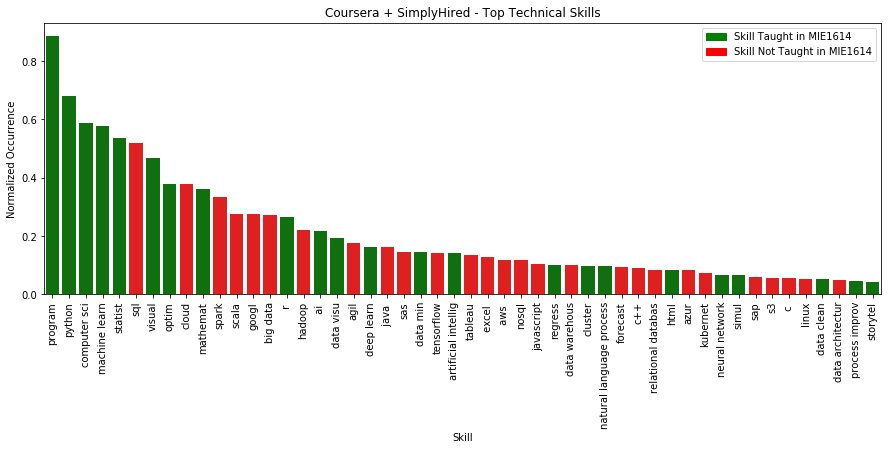

In [76]:
import matplotlib.patches as mpatches
skill=skill_norm
occurrence=occurrence_norm

skill = [x for _,x in sorted(zip(occurrence,skill),reverse=True)]
occurrence = sorted(occurrence,reverse=True)

overall_skill=skill
overall_occurrence=occurrence

top_sk = 50

fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
clrs = ['green' if (x == 'Skill Taught in MIE1614') else 'red' for x in skill_in_course ]
plott=sns.barplot(x=skill[0:top_sk],y=occurrence[0:top_sk],palette=clrs)
plott.set(xlabel='Skill', ylabel='Normalized Occurrence',title='Coursera + SimplyHired - Top Technical Skills')
plott.set_xticklabels(plott.get_xticklabels(), rotation=90)

red_patch = mpatches.Patch(color='red', label='Skill Not Taught in MIE1614')
green_patch = mpatches.Patch(color='green', label='Skill Taught in MIE1614')
plt.legend(handles=[green_patch, red_patch])

plt.show()

We can see that that the course description contains some, but not all of the top skills from Coursera and SimplyHired. In addition, some of the skills that are taught are covered in not as much detail as others (for example, priogramming in R). The list does however contain some insights:

Skills not in MIE 1624 include:
- **Big Data (also: SQL, Spark, Hadoop, NoSQL, Data Warehouse)**
- Data Architecture (also: Kubernetes, s3)
- Certain Programming Languages (including: R, Scala, java, javascript, c)
- Cloud computing (Google, Azure)
- Agile software development
- Certain Stats/Machine learning platforms (TensorFlow, SAS, Excel)
- Data Visualization Software (Tableau)

Overall, most of the most relevant skills are covered extensively in this course. There is a large emphasis on programming in python, machine learning, statistics, data visualization, optimization and general math. In an introductory course, it does not make sense to introduce many programming languages, and python is overwhelmingly the most popular (according to all three datasets). 

The most relevant skills that are missing from the course are related to SQL and Big Data. Therefore, if we were to redesign the course to contain more employable skills, we would add SQL to the course. If we were to remove a certain skill from the course to make room for an intro to SQL, we could remove some of the more advanced machine learning models, and the section on simulation modelling.

Now, let's look at how certain soft skills are covered in the course. Soft skills are not usually explicitly mentioned in the course description. Typically in courses, soft skills are used in course projects. Soft skills "taught" in the course will be identified manually. 

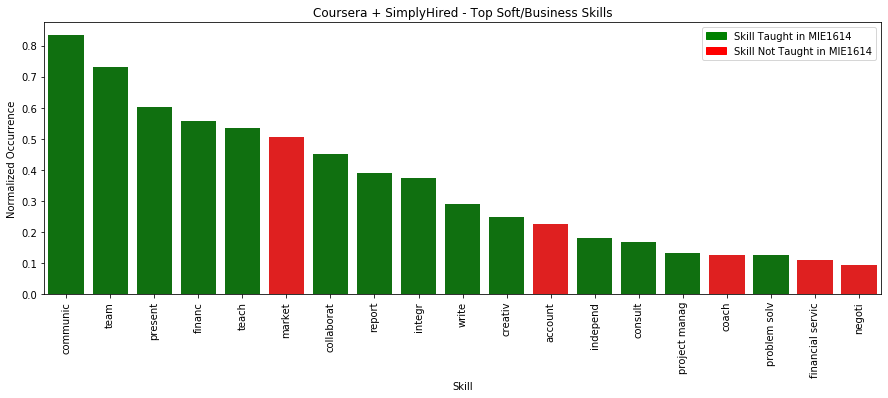

In [77]:
soft_in_course=['Skill Taught in MIE1614',
               'Skill Taught in MIE1614',
               'Skill Taught in MIE1614',
               'Skill Taught in MIE1614',
               'Skill Taught in MIE1614',
               'Skill Not Taught in MIE1614',
               'Skill Taught in MIE1614',
                'Skill Taught in MIE1614',
               'Skill Taught in MIE1614',
               'Skill Taught in MIE1614',
               'Skill Taught in MIE1614',
               'Skill Not Taught in MIE1614',
               'Skill Taught in MIE1614',
               'Skill Taught in MIE1614',
               'Skill Taught in MIE1614',
               'Skill Not Taught in MIE1614',
               'Skill Taught in MIE1614',
               'Skill Not Taught in MIE1614',
               'Skill Not Taught in MIE1614',
               'Skill Not Taught in MIE1614']

skill=soft_skill_norm
occurrence=soft_occurrence_norm

skill = [x for _,x in sorted(zip(occurrence,skill),reverse=True)]
occurrence = sorted(occurrence,reverse=True)

overall_soft_skill=skill
overall_soft_occurrence=occurrence

top_sk = 20

fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
clrs = ['green' if (x == 'Skill Taught in MIE1614') else 'red' for x in soft_in_course ]
plott=sns.barplot(x=skill[0:top_sk],y=occurrence[0:top_sk],palette=clrs)
plott.set(xlabel='Skill', ylabel='Normalized Occurrence',title='Coursera + SimplyHired - Top Soft/Business Skills')
#hue=soft_in_course[0:top_sk]

red_patch = mpatches.Patch(color='red', label='Skill Not Taught in MIE1614')
green_patch = mpatches.Patch(color='green', label='Skill Taught in MIE1614')
plt.legend(handles=[green_patch, red_patch])



plott.set_xticklabels(plott.get_xticklabels(), rotation=90)
plt.show()



It is clear that most of the top 20 soft/business skills from SimplyHired Job descriptions and Coursera courses are taught in MIE 1624. The notable exceptions are marketing and accounting. We can therefore add a marketing aspect to the course assignments. Teamwork, communication, presentation, collaboration are covered extensively in the current course, by way of the course project and presentations. For this reason, the general format of the group presentation project and course project will remain the same, with some more emphasis on marketing in one of the assignments. 

### Aspects of the Course to Remove 
There are some skills in the course curriculum that are not as frequently requested by employers. Therefore, the course curriculum redesign will remove simulation modelling and some of the more advanced machine learning algorithms, which were not as popular among employers as SQL and big data. The final exam will be replaced with an additional assignment, because it does not really teach any additional skills, compared to the assignment format where students more carefully implement more of the course algorithms. Additionally, the code from an assignment remains as an example for the student to use in the future, once the course is over. 

### Aspects to Add to the Course
In place of Simulation Modelling, a lecture on big data will be added. This lecture will be reinforced with an additional assignment with a database that must be accessed in SQL. The marks in the course have been re-allocated to reflect the time spent on the assignments. They typically take over 40 hours, which is excessive for a 15% mark, so they will be worth 18.33% now. 

## 3.2 Redesigned Course Cirriculum

### MIE 1624 Introduction to data science and analytics

#### Data science concepts
- Application areas of quantitative modeling 

#### Python programming, data science software
- Introduction to Python
- Comparison of Python, R and Matlab usage in data science 

#### Basic statistics
- Random variables, sampling
- Distributions and statistical measures
- Hypothesis testing
- Statistics case studies in IPython 

#### Overview of linear algebra
- Linear algebra and matrix computations
- Functions, derivatives, convexity

#### **Intro to Databases**
- **Intro to SQL**
- **Intro to big data** 
- **Aggregate functions and Data Manipulation**

#### Data visualization and visual analytics
- Visual analytics
- Visualizations in Python and visual analytics in IBM Watson Analytics 
- Intro to Tableau

#### Optimization
- Unconstrained non-linear optimization algorithms
- Overview of constrained optimization algorithms
- Optimization case studies in IPython 
- Intro. to Simulation modeling

#### Modeling techniques, regression
- Mathematical modeling process
- Linear regression
- Logistic regression
- Regression case studies in IPython 

#### Advanced machine learning
- Classification (decision trees)
- Advanced supervised machine learning algorithms (Naive Bayes, k-NN, SVM)
- Intro to ensemble learning algorithms (Random Forest, Gradient Boosting)
- ~~Intro to neural networks and deep learning~~
- Text analytics and natural language processing
- Clustering (K-means, Fuzzy C-means, Hierarchical Clustering, DBSCAN)
- Dimensionality reduction
- Association rules
- Overview of reinforcement learning
- Machine learning case studies in IPython 

#### ~~Simulation modeling~~
- ~~Random number generation~~
- ~~Monte Carlo simulations~~
- ~~Simulation case studies in IPython~~ 

#### Storytelling based on analytics, analytical decision making
- Validating analytics
- Storytelling based on analytics
- Decision-making based on analytics


Assignments, Exams and Grading Assignment #1 (**18.33%**), Assignment #2 (**18.33%**), Assignment #3 (**18.33%**), Course Project (30%) In-Class Group Presentation (15%), ~~Final Exam (25%)~~

### 3.2.1 Assignment Descriptions

The current MIE 1624 assignments and projects cover many aspects of data science, but there are some aspects that are missing based on our analysis of job and course data. To this end, the assignments will be revised slightly, including an additional assignment on SQL and big data. 

### In-Class Presentation Assignment

The purpose of the in-class presentation assignment is for students to research and teach a concept in data science to the class. The in-class presentation assignmnet would be unchanged from the current format, however, the topics of the in-class presentations would be modified to account for the content removed from the course. 

**Topic List**

- Group 1 – Basic Statistics
- Group 2 – Hypothesis Test for Categorical Data
- Group 3 - Time Series
- Group 4 - Handling Missing Values and Outlier Detection
- Group 5 - Feature Engineering
- Group 6 - Feature Engineering
- Group 7 - Regularization in Linear Regression 
- Group 8 - Bias Variance Trade-off
- Group 9 - Feature Scaling
- Group 10 - Twitter Text Processing
- Group 11 - Advanced Text Processing
- Group 12 - Job Posting Web-Scraping
- Group 13 - Naive Bayes
- Group 14 - KNN
- Group 15 - SVM
- Group 16 - Random Forest
- Group 17 - Gradient Boosting
- Group 18 - Dimensionality Reduction
- **Group 19 - Simulation Modelling** ~~Recommender System~~
- **Group 20 - Random Number Generation** ~~Reinforcement Learning ~~
- **Group 21 - Monte Carlo Simulations** ~~Simulation Modeling ~~
- **Group 22 - Deep Learning** ~~RNN_LSTMs  ~~
- **Group 23 - Neural Networks** ~~Autoencoders ~~


**Learning Objectives**
1. Develop the ability to work in a team on a consulting project.
2. Research a data science concept of your choice
3. Implement programming algorithms to understand the concepts further, in notebook format
4. Create visualizations to demonstrate the concept
5. Present the data to explain the concept to an audience

Tech Skills (from top 50):
'computer sci', 'python', 'program', 'visual', 'data visu', 'storytel', 'jupyt'

Soft Skills (from top 20):
'team', 'communic', 'collaborat', 'report', 'present', 'creativ', 'consult', 'problem solv', 'independ','project manag', 'write', 'teach', 'time manag'


### Assignment 1  - Big Data, SQL and Visualization

The first assignment would be a big data problem using SQL. The students would be required to scrape the data from the internet, for example job data from indeed or something similar. The purpose of the assignment would be to perform market research on a large group.

**Learning Objectives**
1. Scrape data from the internet using python
2. Implement functionality to parse and clean data according to given requirements.
3. Learn how to use SQL to store and access data
4. Understand how exploring the data by creating visualizations leads to a deeper understanding of the data.
5. Create a short marketing report or presentation about the target demographic

Make a visualization here that shows which skills are covered in each assignment

Tech Skills: 'computer sci', 'python', 'sql', 'statist', 'program', 'mathemat', 'visual', 'big data', 'scala', 'data visu', 'data min', 'tensorflow', 'data warehous', 'relational databas', 'natural language process', 'data clean', 'data architectur', 'html', 'storytel', 'jupyt',  'data explor', 'customer segment', 'data analysis skil'

Soft Skills: 
'communic', 'report', 'present', 'integr', 'market', 'creativ', 'consult', 'problem solv', 'independ', 'write', 'time manag', 

### Assignment 2 - Basic Machine Learning

The second assignment in the redesigned course would have similar learning objectives to the current Assignment 1 in the course offering, but with a greater emphasis on understanding the models being used and how to tune them effectively. For this purpose, a smaller dataset, such as the iris dataset, or a much smaller survey dataset could be used. The assignment would comprise of three analyses (binary classification, multi-class classification and ordinal multi-class classification) to demonstrate the differences between the methods. The assignment would use a smaller dataset, and have less emphasis on data cleaning but more focus on how to tune models effectively and which model parameters are important and markes would be allocated for good model performance. Essentially, the assignment would be to solve more problems that are simpler. 

**Learning Objectives**
1. Understand how to clean and prepare data for machine learning, including working with multiple data types, incomplete data, and categorical data. Perform data standardization/normalization, if necessary, prior to modeling.
2. Understand how to explore data to look for correlations between the features and the target variable.
3. Understand how to apply **Multiple** machine learning algorithms (logistic regression) to the task of classification.
4. Improve on skills and competencies required to compare performance of classification algorithm, including application of performance measurements, statistical hypothesis testing, and visualization of comparisons.
5. Understand how to improve the performance of your model. 
6. Improve on skill and competencies required to collate and present domain specific, evidence-based insights.


Tech Skills: 'python', 'statist', 'program', 'machine learn', 'mathemat', 'visual', 'data visu',  'regress', 'data clean', 'storytel', 'jupyt', 'data explor', 'data analysis skil', 'visual analyit'

Soft Skills: 'communic', 'report', 'present', 'creativ', 'problem solv', 'independ','write', 'time manag', 

### Assignment 3 - Advanced Machine Learning + Natural Language Processing

The second assignment would be similar to the current course. However, we could add in additional data from the twitter users, such as gender, location of user, number of followers number of tweets that the user has made, etc to gain additional insights and improve model accuracy. We would also use less tweets, so that the models would run faster. This would add more of a data cleaning/screening/visualization aspect to this assignment, which would be less of a focus in the first machine learning assignment (Assignment 2) in the redesigned curriculum.

**Learning Objectives**
1. Implement functionality to parse and clean data according to given requirements.
2. Understand how exploring the data by creating visualizations leads to a deeper understanding of the data.
3. Learn about training and testing machine learning algorithms (logistic regression, k-NN, decision trees, random forest, XGBoost).
4. Understand how to apply machine learning algorithms to the task of text classification.
5. Improve on skills and competencies required to collate and present domain specific, evidence-based insights.

Tech Skills: 'computer sci', 'python', 'statist', 'program', 'machine learn', 'mathemat', 'optim', 'visual', 'data visu', 'data min', 'relational databas', 'regress', 'natural language process', 'data clean',  'data architectur', 'javascript', 'storytel', 'jupyt'

Soft Skills: 'communic', 'report', 'present','market',  'creativ', 'problem solv', 'independ', 'write', 'time manag', 


### Course Project

We propose to have a course project with a similar format as the current course, but to make the course project more open ended. We would ask the groups to solve a data science problem of their choice. This would add more of a creative/entrepreneurial aspect to the project, and research based students could potentially apply the course project to their own research. The learning objectives would remain unchanged.

**Potential Topics**
1. Job data analysis (or examine another statscan dataset)
2. Speech/facial analysis
3. Analysis of user data from social media
4. Stock market analysis

**Learning Objectives**
1. Scrape data from the internet (or use another means of collection) and pre-process the data
2. Present visual analytics on the data (to identify trends in the data)
3. Perform machine learning on the data to understand the most important factors
4. Create a business plan based on the analysis to address/solve a problem of their choice
5. Develop presentation skills, reporting skills and teamwork
6. Develop the ability to work in a team on a consulting project.

Tech Skills: 'python', 'statist', 'program', 'machine learn', 'mathemat', 'visual', 'data visu',  'regress', 'data clean', 'storytel', 'jupyt', 'data explor', 'data analysis skil', 'visual analyit'

Soft Skills: 'team', 'communic', 'collaborat', 'report', 'present', 'integr', 'market', 'financ', 'creativ', 'consult', 'problem solv', 'independ', 'account', 'account', 'coach', 'financial servic', 'project manag', 'write', 'ethic', 'teach', 'time manag'

## 4. Analysis of Other University Data Science Programs

We have looked for various universities around the world, which offer programs in Data Science. These programs are offered majorly in three different faculties:

- Faculty of Engineering (Applied Sciences)
- Faculty of Business (Business and Management)
- Faculty of Science (Computer Sciences)

The difference in the faculty offerings is in the core courses, and the pre-requisities. The degree titles also depend on which of the faculty is offering the program. Different program names are used by different universities depending on the faculty offering it; these includes masters in:

- Data Science
- Data Science and Analytics
- Data Science and Machine Learning
- Data Science and Artificial Intelligence
- Management and Artificial Intelligence

Few of the universities offer the program, which is a collaboratory program taught by more than one department; like in University of Waterloo, the program is offered with the collaboration of Faculty of Science (Department of Science) and Faculty of Mathematics.

We have considered the following universities for analysis of other university data science program. The reason for the selection of theseuniversities for the analysis is that all these university program title is **Master of Data Science and Artificial Intelligence**, whichis the program we are developing. Secondly, these universities are in Canada (North America) and Europe. So, it covers the diversity of the regions also. The universities are as follow:

- University of Waterloo (Canada)
- University of London (UK)
- Eindhoven University of Technology (Netherlands)
- Bournemouth University (UK)

Let's have a look on the program websites of these universities:

In [78]:
url = 'https://uwaterloo.ca/graduate-studies-academic-calendar/mathematics/data-science-and-artificial-intelligence/master-data-science-and-artificial-intelligence-mdsai'


In [79]:
# University of Waterloo (Canada)
url = 'https://uwaterloo.ca/graduate-studies-academic-calendar/mathematics/data-science-and-artificial-intelligence/master-data-science-and-artificial-intelligence-mdsai'


In [80]:
# University of London (UK)
url = 'https://london.ac.uk/msc-data-science-and-artificial-intelligence-structure'


In [81]:
# Eindhoven University of Technology (Netherlands)
url = 'https://www.tue.nl/en/education/graduate-school/master-data-science-and-artificial-intelligence/'


In [82]:
# Bournemouth University (UK)
url = 'https://www.bournemouth.ac.uk/study/courses/msc-data-science-artificial-intelligence'


## 4.1 Program Modules

Generally the curriculum in each university is divided in three type of course or modules:

- Fundamental Courses
- Core Courses (Cumpolsary Courses)
- Electives (Optional Courses)

The difference in the different faculty offerings are in the fundamental and core courses. But in general most of the courses are same. The degree focuses are slightly different, as for Business faculty offerings are more focused in management and business along with analytics, whereas the engineering schools are more focused on analytics and minor focus on business.

Moreover, few of the universities have internship oppurtunities (Co-Op or work terms) along with the curriculm and few have projects (term project). We have considered the Co-Op Program (Internship or work term) having one semester as work term. The individual courses have the projects. The reason of selection of the internship over the term project is that intership will offer the real industry experience for the students and they will learn more in the industry environment. In industry they can directly apply their academic knowledge and this internship will act as the bridge for their academic career to the industrial career. There is the importance of the term project also, as it gives the students to learn end-to-end design cycle. This design study is vital in the engineering degree program. So, we will be supplimenting it in the form of course projects, which will give the students exposure to the complete design cycle and hands-on experience to the business oriented projects. These projects will well-prepare the students for the industry.

## 4.2 Courses

We decided to divide our data science degree program into 4 semesters. Each semester consists of three courses, with the fourth semester being a work term. The first semester is a foundational semester wherein students take courses that we believe to be essential background knowledge for mastering top industry skills. In semester two, students are then introduced to core courses that provide them an overview of the two major specializations in the data science industry that we saw based on our results: big data, and artificial intelligence. In semester three, the student is able to stream and focus more intensely on one of these specializations. Finally in semester four, the students are required to complete an industry work term in order to gain practical experience. 

**Semester 1**
1. Introduction to Data Science and Analytics
2. Statistics & Mathematics for Data Science
3. Data Analytics & Visualization

**Semester 2**
4. Machine Learning
5. Big Data
6. General Stream Elective

**Semester 3**
- 3 Artificial Intelligence Stream Electives OR
- 3 Big Data Stream Electives

**Semester 4**
- Internship (4-6 months)

Below is a more detailed breakdown of course content:

### 4.2.1 Introduction to Data Science and Analytics

We have redesigned MIE 1624 and made few changes in the course. This course will serve as the introductory course for our degree program and will introduce most of the concepts taught throughout the program.

### Skills you Gain

- Python
- Pandas
- Scikit Learn
- SQL
- Tableau
- Machine Learning
- Big Data
- Visualization
- Visual Storytelling

### Course Outline

- Data science concepts
  - Application areas of quantitative modeling
- Python programming, data science software
  - Introduction to Python
  - Comparison of Python, R and Matlab usage in data science
- Basic statistics
  - Random variables, sampling
  - Distributions and statistical measures
  - Hypothesis testing
  - Statistics case studies in IPython
- Overview of linear algebra
  - Linear algebra and matrix computations
  - Functions, derivatives, convexity
- Intro to Databases
  - Intro to SQL
  - Intro to big data
  - Aggregate functions and Data Manipulation
- Data visualization and visual analytics
  - Visual analytics
  - Visualizations in Python and visual analytics in IBM Watson Analytics
  - Intro to Tableau
- Optimization
  - Unconstrained non-linear optimization algorithms
  - Overview of constrained optimization algorithms
  - Optimization case studies in IPython
  - Intro. to Simulation modeling
- Modeling techniques, regression
  - Mathematical modeling process
  - Linear regression
- Modeling techniques, regression
  - Logistic regression
  - Regression case studies in IPython
- Advanced machine learning
  - Classification (decision trees)
  - Advanced supervised machine learning algorithms (Naive Bayes, k-NN, SVM)
  - Intro to ensemble learning algorithms (Random Forest, Gradient Boosting)
- Advanced machine learning  
  - Text analytics and natural language processing
  - Clustering (K-means, Fuzzy C-means, Hierarchical Clustering, DBSCAN)
  - Dimensionality reduction
  - Association rules
  - Overview of reinforcement learning
  - Machine learning case studies in IPython
- Storytelling based on analytics, analytical decision making
  - Validating analytics
  - Storytelling based on analytics
  - Decision-making based on analytics

source: https://www.mie.utoronto.ca/wp-content/uploads/2019/08/MIE1624H-Course-Outline-Fall-2019.pdf

### 4.2.2 Statistics & Mathematics for Data Science

Most of the universities offer a course of Statistics for Data Science. This course reviews the statistics concepts required for data science program. Instead of having a course only for Statistics, we have introduce a foundation course of **Statistics & Mathematics for Data Science** in our program. This course will revise the concepts of Linear Algebra and Optimization, along with Statistics. These concepts are essential for machine learning models. So, we will be reviewing these concepts at the foundation semester of the program.

### Skills you Gain

- Linear algebra
- Optimization
- Statistical Testing
- Inference
- Regression
- Monte Carlo simulation
- Linear Regression


### Course Outline

- Introduction
  - Working with data
  - Data collection
    - Observational data
    - Designing experiments
  - Sampling
  - Bias

- Probability Theory
  - Probability basics 
    - Axioms of probability
    - Conditional probability
    - Random variables
    - Expectation
    - Independence

- Probability Theory
  - Distribution of Random Variables
  - Multivariate distributions
  - Introduction to concentration bounds
  - Laws of large numbers
  - Central limit theorem

- Vectors and matrices
  - Vector spaces
  - Singular value decomposition
  - Eigendecomposition
  
- Geometry of matrices and derivatives
  - Linear transformations
  - Partial derivatives
  - Least squares

- Statistical Significance and Tests of Hypothesis
  - Hypothesis testing
  - The t-distribution
  - Paired data
  - Difference between two means
  - Inference for categorical data

- Optimization
  - Matrix calculus
  - Gradient descent
  - Coordinate descent
  - Introduction to convex optimization

- Statistics
  - Maximum a posteriori and maximum likelihood estimation
  - Minimum mean-squared error estimation
  - Confidence intervals
  
- Model Building
  - Modeling
  - Statistical modeling
  - Training and testing
  - Evaluating models
   - Measures of errors (loss functions)
   - Quadratic loss
   - Cross validation
   - Lift charts
   - ROC curves
   - Recall-Precision curves

- Linear Regression and Correlation
  - Numerical prediction
  - Ordinary least square regression
  - Preconditions for OLS to be valid

- Introduction to Bayesian Inference
  - Bayes rule
  - Bayesian inference
  - PyMC
  - STAN

- Markov Chain Monte Carlo

sources: 
1. https://london.ac.uk/courses/mathematics-and-statistics-data-science
2. https://cims.nyu.edu/~cfgranda/pages/DSGA1002_fall15/index.html

### 4.2.3 Data Analytics & Visualization

The course offered at various universities are with the following titles:
- Data Visualization
- Exploratory Data Analysis
- Exploratory Data Analysis and Visualization
- Data Analysis and Visualization
- Data Analytics

We have considered the course title as **Data Analytics & Visualization**. This course will provide the fundamental knowledge of data analysis and visualization and intoduce the visual analytics as well. So, this course along with **Introduction to Data Science** and **Statistics & Mathematics for Data Science** will provide the foundation of our masters program, and prepare the students for the next semesters.

### Skills you Gain

- Data Visualization
- Tableau 
- R, R studio
- Tableau Storypoint
- Principal Components Analysis (PCA)
- Metric Multidimensional Scaling (MDS)
- Stochastic Neighbor Embedding (SNE, t-SNE)
- Regression
- Clasification
- Clustering

### Course Outline

- Introduction to data analytics visualization
  - Data analytics concepts
  - Data visualization and application
  - Industry overview
  - Introduction to R and R studio
  - Introduction to Tabeleau
- Review of Statistics
  - Random variables sampling
  - Data types and distributions
  - Statistical parameters
  - Hypothesis testing
- Data Anlytics concepts
  - Data preparation
  - Data visualization
  - Feature Engineering
- Data Anlytics in R
  - Basic operations in R
  - Visualization in R
    - ggplot
    - Leaflet
    - Highcharter
  - Dataframe in R
  - Analytics applications with R
- Dimensionality Reduction - Linear Methods
  - Principal Components Analysis (PCA)
  - Dual PCA
  - Supervised Principal Components Analysis
- Dimensionality Reduction - Linear Methods
  - Metric Multidimensional Scaling (MDS)
  - Landmark MDS (Nystrom Approximation)
  - Non-negative Matrix Factorization
- Dimensionality Reduction - Nonlinear Methods
  - Kernel Principal Components Analysis
  - Stochastic Neighbor Embedding (SNE, t-SNE)
  - Unified Framework for Dimensionality reduction
- Regression and Classification
  - Linear Regression
  - Logistic Regression
  - Classification
  - Decision Trees
- Clustering
  - Vector Quantization
  - K-means
  - K-medoids
  - Probabilistic Clustering
- Clustering 
  - Spectral Clustering
  - Hierarchical Clustering
  - Affinity Propagation
  - Cluster validation
- Advanced data visualization in Tableau
  - Aggregate functions
  - Mapping Techniques
  - Advanced data preparation in Tableau
  - Building and Customizing visualization
  - Creating dashboard with live and extract data
- Case study of data visualization

source:
1. http://qmss.columbia.edu/sites/default/files/STAT%20GR5702%20Exploratory%20Data%20Analysis%20and%20Visualization%20%28EDAV%29%20Syllabus%20Spring%202018.pdf

2. https://uwaterloo.ca/data-analytics/sites/ca.data-analytics/files/uploads/files/f14stat842outline_v1.pdf
3. http://www.math.uwaterloo.ca/~aghodsib/courses/f06stat890/f06stat890.html

### 4.2.4 Introduction to Machine Learning

This is one the course course we selected for our second semester of the program. This course will introduce the concepts of Machine Learning to the students, and enable them to pursue the specialization in Machine Learning stream. It will familirize students with the basic machine learning and artificial intelligence (AI) tools for developing the analytics.


### Skills you Gain

- Machine Learning
- Deep Learning
- Python
- Pandas
- Statmodel
- Scikit Learn
- Keras
- Tensorflow
- Theano
- Caffe

### Course Outline

- Introduction and Basic Concepts
  - Introduction - What is Machine Learning
  - Building blocks
    - MLE
    - Bayesian
    - Estimation
    - MAP
    - Decision Theory
    - Model-free
    - Risk Minimization

- Introduction and Basic Concepts
  - Classification
  - K-nearest Neighbours
  
- Parametric Estimation and Prediction
  - Linear Regression
  - Regularization
  - Logistic Regression

- Parametric Estimation and Prediction
  - Naive Bayes
  - Disciminative vs generative
  - Support Vector Machines
  
- Parametric Estimation and Prediction
  - Kernels
  - Decision Trees
  - Boosting
  - Bagging
  
- Neural Networks
  - Perceptron
  - Neural nets
  - Deep nets
  - Back propagation
  
- Learning Theory
  - Generalization
  - Model selection
  - Learning Theory

- Unsupervised Learning
  - Clustering
  - Representation Learning
  
- Graphical Models and Structured Prediction
  - Graphical Models
  
- Graphical Models and Structured Prediction
  - Sequence Model

- Deep Neural Networks
  - Convolutional Neural Networks
  - Recurrent Neural Networks
  - Generative Adversarial Networks

- Special Topics
  - Reinforcement learning
  - Deep Reinforcement learning


source: https://www.cs.cmu.edu/~lwehbe/10701_S19/files/Syllabus.pdf

### 4.2.5  Introduction to Big Data

This is one the course course we selected for our second semester of the program This course will introduce the concepts of Big Data to the students, and enable them to pursue the specialization in Big Data stream. 

### Skills you Gain

- Hadoop
- MapReduce
- Elastic Map Reduce (EMR)
- Apache Spark
- Distributed computing
- Hive
- Impala
- Weka
- PySpark
- Scala
- Databricks
- SparkML
- Graph theory

#### Course Outline

- Introduction to Hadoop
  - Definition of big data
  - Big data industry review
  - History of Hadoop and distributed computing
  - Brief overview of HDFS, Yarn, MapReduce, Spark
  - Review of the big data resources

- Enterprise Hadoop and Hadoop basics
  - HDFS 
  - YARN
  - Launch of the cluster environment

- SQL
  - Programming languages: overview, object-oriented vs functional, scripting languages
  - Big data languages: overview of Spark, Hive & Impala
  - SQL: most important commands
  - Hive vs Impala: comparison between two SQL languages and environments

- Elastic Map Reduce
  - Introduction to EMR
  - Practice on EMR notebooks

- NoSQL Databases
  - MongoDB
  - Neo4j
  - Cassandra

- Spark, introduction
  - Introduction into Spark
  - History of Spark, its evolution, libraries
  - Review of Spark APIs: PySpark, Scala, R and Java
  - Spark backend transformations
  - Practice sessions with DataBricks, Scala

- Spark, syntax
  - Spark session
  - Import/export of data
  - Spark SQL: functional and scripting
  - Working with SQL images
  - Most important Scala functions

- Spark: Data Preparation and Feature Transformation for ML
  - Feature preparation: overview of main steps (in Spark)
  - Handling nulls/NaNs, missing values, outliers, normalization
  - Spark libraries for feature transformation
  - Feature transformation: dimensionality reduction, clustering, conversion from categorical to numerical
  - Principle component analysis
  - Regularization: L1, L2

- Spark, model development, pipelines, evaluation metrics
  - Model development process and necessary steps
  - Spark pipelines
  - TrainTestSplit and CrossValidation
  - Regularization: L1, L2
  - Model evaluation metrics for different classes of models

- Spark ML: Multivariate analysis and time-series analysis
  - Multivariate ML models in Spark: regression trees
  - Time-series analysis

- Advanced data science topics
  - Graph theory
  - Deep learning libraries 

- Cloud for Big Data
  - Cloud for big data
  - AWS Cloud
  - Azure Cloud
  - IBM Cloud
  - Running analytics on Cloud
  
Source: https://www.mie.utoronto.ca/wp-content/uploads/2019/08/20193-MIE1628H.pdf

### 4.2.6 General Electives Courses

Students can pick one of the following courses an elective for the second semester of the program. The purpose of the course is to provide the depth knowlege of optimization and simulation to the students. 
- Optimization for Data Science
- Convex Optimization and Analysis
- Topics in Continuous Optimization
- Advanced Topics in Computational Statistics
- Computational Inference
- Simulation modelling and analysis
- Modeling and Simulation for Data Science

### 4.2.6 Electives for Machine Learning Stream

Students have to pick three of the following courses as electives for the specialization. The purpose of the courses is to make students the specialist in machine learning.

- Machine Learning: Statistical and Computational Foundations
- Introduction to Artificial Intelligence
- Probabilistic Inference and Machine Learning
- Explainable Data Analytics
- Data Mining and Machine Learning
- AI and Machine Learning
- Deep Learning
- Reinforcement Learning

### 4.2.7 Electives for Big Data Stream

Students have to pick three of the following courses as electives for the specialization. The purpose of the courses is to make students the specialist in big data.

- Distributed Systems
- Database Engineering
- Parallel and Distributed Database Systems
- Advanced Topics in Databases
- Advanced Topics in Distributed Computing
- Advanced Topics in Data Visualization
- Advanced Management of Big Data Analytics
- Data Analytics, Big Data, and Predictive Analytics

We will now search out course curriculum to make sure it covers essential skills identified in our job (SimplyHired) and course (Coursera) data. 

In [83]:
desc_str=['4.2.1 Introduction to Data Science and Analytics',
'We have redesigned MIE 1624 and made few changes in the course. This course will serve as the introductory course for our degree program and will introduce most of the concepts taught throughout the program.',
'Skills you Gain',
'Python',
'Pandas',
'Scikit Learn',
'SQL',
'Tableau',
'Machine Learning',
'Big Data',
'Visualization',
'Visual Storytelling',
'Course Outline',
'Data science concepts',
'Application areas of quantitative modeling',
'Python programming, data science software',
'Introduction to Python',
'Comparison of Python, R and Matlab usage in data science',
'Basic statistics',
'Random variables, sampling',
'Distributions and statistical measures',
'Hypothesis testing',
'Statistics case studies in IPython',
'Overview of linear algebra',
'Linear algebra and matrix computations',
'Functions, derivatives, convexity',
'Intro to Databases',
'Intro to SQL',
'Intro to big data',
'Aggregate functions and Data Manipulation',
'Data visualization and visual analytics',
'Visual analytics',
'Visualizations in Python and visual analytics in IBM Watson Analytics',
'Intro to Tableau',
'Optimization',
'Unconstrained non-linear optimization algorithms',
'Overview of constrained optimization algorithms',
'Optimization case studies in IPython',
'Intro. to Simulation modeling',
'Modeling techniques, regression',
'Mathematical modeling process',
'Linear regression',
'Modeling techniques, regression',
'Logistic regression',
'Regression case studies in IPython',
'Advanced machine learning',
'Classification (decision trees)',
'Advanced supervised machine learning algorithms (Naive Bayes, k-NN, SVM)',
'Intro to ensemble learning algorithms (Random Forest, Gradient Boosting)',
'Advanced machine learning',
'Text analytics and natural language processing',
'Clustering (K-means, Fuzzy C-means, Hierarchical Clustering, DBSCAN)',
'Dimensionality reduction',
'Association rules',
'Overview of reinforcement learning',
'Machine learning case studies in IPython',
'Storytelling based on analytics, analytical decision making',
'Validating analytics',
'Storytelling based on analytics',
'Decision-making based on analytics',
'source: https://www.mie.utoronto.ca/wp-content/uploads/2019/08/MIE1624H-Course-Outline-Fall-2019.pdf',
'',
'4.2.2 Statistics & Mathematics for Data Science',
'Most of the universities offer a course of Statistics for Data Science. This course reviews the statistics concepts required for data science program. Instead of having a course only for Statistics, we have introduce a foundation course of Statistics & Mathematics for Data Science in our program. This course will revise the concepts of Linear Algebra and Optimization, along with Statistics. These concepts are essential for machine learning models. So, we will be reviewing these concepts at the foundation semester of the program.',
'',
'Skills you Gain',
'Linear algebra',
'Optimization',
'Statistical Testing',
'Inference',
'Regression',
'Monte Carlo simulation',
'Linear Regression',
'Course Outline',
'Introduction',
'',
'Working with data',
'Data collection',
'Observational data',
'Designing experiments',
'Sampling',
'Bias',
'Probability Theory',
'',
'Probability basics',
'Axioms of probability',
'Conditional probability',
'Random variables',
'Expectation',
'Independence',
'Probability Theory',
'',
'Distribution of Random Variables',
'Multivariate distributions',
'Introduction to concentration bounds',
'Laws of large numbers',
'Central limit theorem',
'Vectors and matrices',
'',
'Vector spaces',
'Singular value decomposition',
'Eigendecomposition',
'Geometry of matrices and derivatives',
'',
'Linear transformations',
'Partial derivatives',
'Least squares',
'Statistical Significance and Tests of Hypothesis',
'',
'Hypothesis testing',
'The t-distribution',
'Paired data',
'Difference between two means',
'Inference for categorical data',
'Optimization',
'',
'Matrix calculus',
'Gradient descent',
'Coordinate descent',
'Introduction to convex optimization',
'Statistics',
'',
'Maximum a posteriori and maximum likelihood estimation',
'Minimum mean-squared error estimation',
'Confidence intervals',
'Model Building',
'',
'Modeling',
'Statistical modeling',
'Training and testing',
'Evaluating models',
'Measures of errors (loss functions)',
'Quadratic loss',
'Cross validation',
'Lift charts',
'ROC curves',
'Recall-Precision curves',
'Linear Regression and Correlation',
'',
'Numerical prediction',
'Ordinary least square regression',
'Preconditions for OLS to be valid',
'Introduction to Bayesian Inference',
'',
'Bayes rule',
'Bayesian inference',
'PyMC',
'STAN',
'Markov Chain Monte Carlo',
'',
'sources:',
'',
'https://london.ac.uk/courses/mathematics-and-statistics-data-science',
'https://cims.nyu.edu/~cfgranda/pages/DSGA1002_fall15/index.html',
'4.2.3 Data Analytics & Visualization',
'The course offered at various universities are with the following titles:',
'',
'Data Visualization',
'Exploratory Data Analysis',
'Exploratory Data Analysis and Visualization',
'Data Analysis and Visualization',
'Data Analytics',
'We have considered the course title as Data Analytics & Visualization. This course will provide the fundamental knowledge of data analysis and visualization and intoduce the visual analytics as well. So, this course along with Introduction to Data Science and Statistics & Mathematics for Data Science will provide the foundation of our masters program, and prepare the students for the next semesters.',
'',
'Skills you Gain',
'Data Visualization',
'Tableau',
'R, R studio',
'Tableau Storypoint',
'Principal Components Analysis (PCA)',
'Metric Multidimensional Scaling (MDS)',
'Stochastic Neighbor Embedding (SNE, t-SNE)',
'Regression',
'Clasification',
'Clustering',
'Course Outline',
'Introduction to data analytics visualization',
'Data analytics concepts',
'Data visualization and application',
'Industry overview',
'Introduction to R and R studio',
'Introduction to Tabeleau',
'Review of Statistics',
'Random variables sampling',
'Data types and distributions',
'Statistical parameters',
'Hypothesis testing',
'Data Anlytics concepts',
'Data preparation',
'Data visualization',
'Feature Engineering',
'Data Anlytics in R',
'Basic operations in R',
'Visualization in R',
'ggplot',
'Leaflet',
'Highcharter',
'Dataframe in R',
'Analytics applications with R',
'Dimensionality Reduction - Linear Methods',
'Principal Components Analysis (PCA)',
'Dual PCA',
'Supervised Principal Components Analysis',
'Dimensionality Reduction - Linear Methods',
'Metric Multidimensional Scaling (MDS)',
'Landmark MDS (Nystrom Approximation)',
'Non-negative Matrix Factorization',
'Dimensionality Reduction - Nonlinear Methods',
'Kernel Principal Components Analysis',
'Stochastic Neighbor Embedding (SNE, t-SNE)',
'Unified Framework for Dimensionality reduction',
'Regression and Classification',
'Linear Regression',
'Logistic Regression',
'Classification',
'Decision Trees',
'Clustering',
'Vector Quantization',
'K-means',
'K-medoids',
'Probabilistic Clustering',
'Clustering',
'Spectral Clustering',
'Hierarchical Clustering',
'Affinity Propagation',
'Cluster validation',
'Advanced data visualization in Tableau',
'Aggregate functions',
'Mapping Techniques',
'Advanced data preparation in Tableau',
'Building and Customizing visualization',
'Creating dashboard with live and extract data',
'Case study of data visualization',
'source:',
'',
'http://qmss.columbia.edu/sites/default/files/STAT%20GR5702%20Exploratory%20Data%20Analysis%20and%20Visualization%20%28EDAV%29%20Syllabus%20Spring%202018.pdf',
'',
'https://uwaterloo.ca/data-analytics/sites/ca.data-analytics/files/uploads/files/f14stat842outline_v1.pdf',
'',
'http://www.math.uwaterloo.ca/~aghodsib/courses/f06stat890/f06stat890.html',
'',
'4.2.4 Introduction to Machine Learning',
'This is one the course course we selected for our second semester of the program. This course will introduce the concepts of Machine Learning to the students, and enable them to pursue the specialization in Machine Learning stream. It will familirize students with the basic machine learning and artificial intelligence (AI) tools for developing the analytics.',
'',
'Skills you Gain',
'Machine Learning',
'Deep Learning',
'Python',
'Pandas',
'Statmodel',
'Scikit Learn',
'Keras',
'Tensorflow',
'Theano',
'Caffe',
'Course Outline',
'Introduction and Basic Concepts',
'',
'Introduction - What is Machine Learning',
'Building blocks',
'MLE',
'Bayesian',
'Estimation',
'MAP',
'Decision Theory',
'Model-free',
'Risk Minimization',
'Introduction and Basic Concepts',
'',
'Classification',
'K-nearest Neighbours',
'Parametric Estimation and Prediction',
'',
'Linear Regression',
'Regularization',
'Logistic Regression',
'Parametric Estimation and Prediction',
'',
'Naive Bayes',
'Disciminative vs generative',
'Support Vector Machines',
'Parametric Estimation and Prediction',
'',
'Kernels',
'Decision Trees',
'Boosting',
'Bagging',
'Neural Networks',
'',
'Perceptron',
'Neural nets',
'Deep nets',
'Back propagation',
'Learning Theory',
'',
'Generalization',
'Model selection',
'Learning Theory',
'Unsupervised Learning',
'',
'Clustering',
'Representation Learning',
'Graphical Models and Structured Prediction',
'',
'Graphical Models',
'Graphical Models and Structured Prediction',
'',
'Sequence Model',
'Deep Neural Networks',
'',
'Convolutional Neural Networks',
'Recurrent Neural Networks',
'Generative Adversarial Networks',
'Special Topics',
'',
'Reinforcement learning',
'Deep Reinforcement learning',
'source: https://www.cs.cmu.edu/~lwehbe/10701_S19/files/Syllabus.pdf',
'',
'4.2.5 Introduction to Big Data',
'This is one the course course we selected for our second semester of the program This course will introduce the concepts of Big Data to the students, and enable them to pursue the specialization in Big Data stream.',
'',
'Skills you Gain',
'Hadoop',
'MapReduce',
'Elastic Map Reduce (EMR)',
'Apache Spark',
'Distributed computing',
'Hive',
'Impala',
'Weka',
'PySpark',
'Scala',
'Databricks',
'SparkML',
'Graph theory',
'Course Outline',
'Introduction to Hadoop',
'',
'Definition of big data',
'Big data industry review',
'History of Hadoop and distributed computing',
'Brief overview of HDFS, Yarn, MapReduce, Spark',
'Review of the big data resources',
'Enterprise Hadoop and Hadoop basics',
'',
'HDFS',
'YARN',
'Launch of the cluster environment',
'SQL',
'',
'Programming languages: overview, object-oriented vs functional, scripting languages',
'Big data languages: overview of Spark, Hive & Impala',
'SQL: most important commands',
'Hive vs Impala: comparison between two SQL languages and environments',
'Elastic Map Reduce',
'',
'Introduction to EMR',
'Practice on EMR notebooks',
'NoSQL Databases',
'',
'MongoDB',
'Neo4j',
'Cassandra',
'Spark, introduction',
'',
'Introduction into Spark',
'History of Spark, its evolution, libraries',
'Review of Spark APIs: PySpark, Scala, R and Java',
'Spark backend transformations',
'Practice sessions with DataBricks, Scala',
'Spark, syntax',
'',
'Spark session',
'Import/export of data',
'Spark SQL: functional and scripting',
'Working with SQL images',
'Most important Scala functions',
'Spark: Data Preparation and Feature Transformation for ML',
'',
'Feature preparation: overview of main steps (in Spark)',
'Handling nulls/NaNs, missing values, outliers, normalization',
'Spark libraries for feature transformation',
'Feature transformation: dimensionality reduction, clustering, conversion from categorical to numerical',
'Principle component analysis',
'Regularization: L1, L2',
'Spark, model development, pipelines, evaluation metrics',
'',
'Model development process and necessary steps',
'Spark pipelines',
'TrainTestSplit and CrossValidation',
'Regularization: L1, L2',
'Model evaluation metrics for different classes of models',
'Spark ML: Multivariate analysis and time-series analysis',
'',
'Multivariate ML models in Spark: regression trees',
'Time-series analysis',
'Advanced data science topics',
'',
'Graph theory',
'Deep learning libraries',
'Cloud for Big Data',
'',
'Cloud for big data',
'AWS Cloud',
'Azure Cloud',
'IBM Cloud',
          'Google cloud',
'Running analytics on Cloud',
'Source: https://www.mie.utoronto.ca/wp-content/uploads/2019/08/20193-MIE1628H.pdf',
'',
'4.2.6 General Electives Courses',
'Students can pick one of the following courses an elective for the second semester of the program. The purpose of the course is to provide the depth knowlege of optimization and simulation to the students.',
'',
'Optimization for Data Science',
'Convex Optimization and Analysis',
'Topics in Continuous Optimization',
'Advanced Topics in Computational Statistics',
'Computational Inference',
'Simulation modelling and analysis',
'Modeling and Simulation for Data Science',
'4.2.6 Electives for Machine Learning Stream',
'Students have to pick three of the following courses as electives for the specialization. The purpose of the courses is to make students the specialist in machine learning.',
'',
'Machine Learning: Statistical and Computational Foundations',
'Introduction to Artificial Intelligence',
'Probabilistic Inference and Machine Learning',
'Explainable Data Analytics',
'Data Mining and Machine Learning',
'AI and Machine Learning',
'Deep Learning',
'Reinforcement Learning',
'4.2.7 Electives for Big Data Stream',
'Students have to pick three of the following courses as electives for the specialization. The purpose of the courses is to make students the specialist in big data.',
'',
'Distributed Systems',
'Database Engineering',
'Parallel and Distributed Database Systems',
'Advanced Topics in Databases',
'Advanced Topics in Distributed Computing',
'Advanced Topics in Data Visualization',
'Advanced Management of Big Data Analytics',
'Data Analytics, Big Data, and Predictive Analytics',
'computer science']

Now we will search the description to see if the new data science program contains the top technical skills from the coursera courses and the SimplyHired jobs:

In [84]:
# Import the data from the csv file we created with our RSS feed processor
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

course_skill_count= np.zeros(len(overall_skill))
skill_in_course=[]

course_desc=str(desc_str)


course_desc=re.sub('<.*?>', '', str(course_desc))
# Remove non-alphabetic values and set all letters to lowercase
#text = re.sub("[^A-Za-z']+", ' ', text).lower()
course_desc = Punctuation(course_desc)
course_desc = course_desc.lower()

i=0
for skill in overall_skill:
    if course_desc.find(skill) >=0:
        course_skill_count[i] = course_skill_count[i]+1
        skill_in_course.append('Skill Taught in MIE1614')
    else:
        skill_in_course.append('Skill Not Taught in MIE1614')

    i=i+1


Now we will color our aggregated coursera + SimplyHired skills lists based on which skills are contained in  the new curriculum:

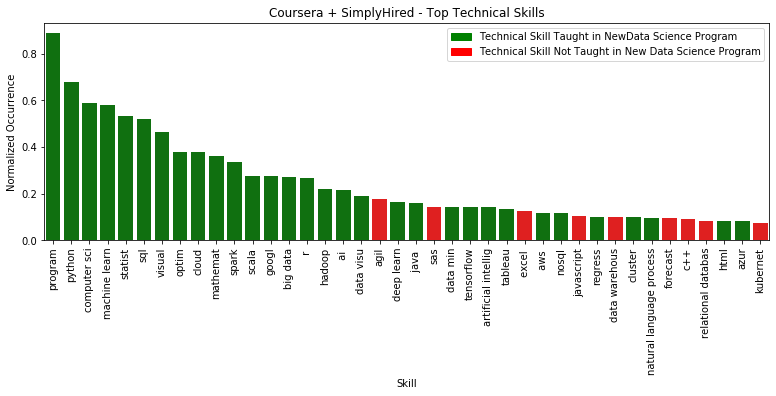

In [86]:
import matplotlib.patches as mpatches
skill=skill_norm
occurrence=occurrence_norm

skill = [x for _,x in sorted(zip(occurrence,skill),reverse=True)]
occurrence = sorted(occurrence,reverse=True)

overall_skill=skill
overall_occurrence=occurrence

top_sk = 40

fig_dims = (13, 4)
fig, ax = plt.subplots(figsize=fig_dims)
clrs = ['green' if (x == 'Skill Taught in MIE1614') else 'red' for x in skill_in_course ]
plott=sns.barplot(x=skill[0:top_sk],y=occurrence[0:top_sk],palette=clrs)
plott.set(xlabel='Skill', ylabel='Normalized Occurrence',title='Coursera + SimplyHired - Top Technical Skills')
plott.set_xticklabels(plott.get_xticklabels(), rotation=90)

red_patch = mpatches.Patch(color='red', label='Technical Skill Not Taught in New Data Science Program')
green_patch = mpatches.Patch(color='green', label='Technical Skill Taught in NewData Science Program')
plt.legend(handles=[green_patch, red_patch])

plt.show()

As we can see, the new curriculum covers all of the top skills related to data science. As for soft skills, the program will ensure all are covered in the course projects, with special emphasis on business skills, communication and teamwork.

## 5. Discussion

This report presented an analysis of current industry, online course, and academic course trends related to data science. We web-scraped job postings and online courses from Simplyhired and Coursera and were able to look at the technical and business skills that are in highest demand from employers. The 2018 and 2019 Kaggle data scientist surveys allowed us to see what skills are possessed by those with the highest paying salaries, and provided insight into the tools being used by current professionals. Finally, we analyzed existing university graduate degree programs in data science to understand current global trends in education. Based on these data, we were able to identify gaps between current university courses and industry demands. We have proposed a new design for a data science graduate degree program, as well as an introductory data science course. 

For the design of the degree program, we limited our research to a small sample of university courses. We chose to do this in order to increase the depth of which we can look into the programs, as opposed to spending time analyzing many different programs. This choice was made partially in the interest of time, noting that many of these programs offer similar courses. Again, it may be possible that this sample is biased, and thus the structure/design of our program is biased.